# 1. Imports & Miscs

In [2]:
# import necessary libraries for the notebook
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from nltk import ne_chunk
import networkx as nx
from fa2 import ForceAtlas2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from colour import Color
import re
import community
import random
from wordcloud import WordCloud, STOPWORDS
import string
import math
from collections import Counter
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)
from prettytable import PrettyTable
import operator

# 2. Data Preparation

## 2.1 Data Cleaning

In [0]:
# read in the file
path = 'ml-latest/'

file1 = 'genome-scores.csv'
fullpath1 = path + file1
df_genome_scores = pd.read_csv(fullpath1)

file2 = 'genome-tags.csv'
fullpath2 = path + file2
df_genome_tags = pd.read_csv(fullpath2)

file3 = 'links.csv'
fullpath3 = path + file3
df_links = pd.read_csv(fullpath3)

file4 = 'movies.csv'
fullpath4 = path + file4
df_movies = pd.read_csv(fullpath4)

file5 = 'ratings.csv'
fullpath5 = path + file5
df_ratings = pd.read_csv(fullpath5)

file6 = 'tags.csv'
fullpath6 = path + file6
df_tags = pd.read_csv(fullpath6)

In [0]:
# set the variables type for genome scores dataset 
df_genome_scores["movieId"] = df_genome_scores["movieId"].astype(str)
df_genome_scores["tagId"] = df_genome_scores["tagId"].astype(str)
df_genome_scores["relevance"] = pd.to_numeric(df_genome_scores["relevance"])
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000


In [0]:
# set the variables type for genome tags dataset 
df_genome_tags["tagId"] = df_genome_tags["tagId"].astype(str)
df_genome_tags["tag"] = df_genome_tags["tag"].astype(str)
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [0]:
# set the variables type for links dataset 
df_links["movieId"] = df_links["movieId"].astype(str)
df_links["imdbId"] = df_links["imdbId"].astype(str)
df_links["tmdbId"] = df_links["tmdbId"].astype(str)
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [0]:
# set the variables type for movies dataset 
df_movies["movieId"] = df_movies["movieId"].astype(str)
df_movies["title"] = df_movies["title"].astype(str)
df_movies["genres"] = df_movies["genres"].astype(str)
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
# set the variables type for ratings dataset 
df_ratings["userId"] = df_ratings["userId"].astype(str)
df_ratings["movieId"] = df_ratings["movieId"].astype(str)
df_ratings["rating"] = pd.to_numeric(df_ratings["rating"])
df_ratings["timestamp"] = pd.to_numeric(df_ratings["timestamp"])
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [0]:
# set the variables type for tags dataset 
df_tags["userId"] = df_tags["userId"].astype(str)
df_tags["movieId"] = df_tags["movieId"].astype(str)
df_tags["tag"] = df_tags["tag"].astype(str)
df_tags["timestamp"] = pd.to_numeric(df_tags["timestamp"])
df_tags.head()

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195


In [0]:
# creation of master dataset for tag
# will be merging "df_genome_scores" and "df_genome_tags" based on the primary key tagId
df_tag_master = df_genome_tags.merge(df_genome_scores, on = "tagId", how = 'outer', suffixes = ["_tags", "_scores"])
df_tag_master.head()

,tagId,tag,movieId,relevance
0,1,007,1,0.02900
1,1,007,2,0.03625
2,1,007,3,0.04150
3,1,007,4,0.03350
4,1,007,5,0.04050


In [0]:
# creation of master dataset for movie
# will be merging "df_links" and "df_movies" based on the primary key movieId
df_movie_master = df_movies.merge(df_links, on = "movieId", how = 'outer', suffixes = ["_movies", "_links"])
df_movie_master.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [0]:
# creation of master dataset for users
# will be merging "df_ratings" and "df_tags" based on the combined primary key userId and movieId

# created primary key, concat of useId and movieId
df_ratings["userId_movieId"] = df_ratings["userId"] + df_ratings["movieId"]
df_tags["userId_movieId"] = df_tags["userId"] + df_tags["movieId"]                                               

In [0]:
df_ratings.head()

,userId,movieId,rating,timestamp,userId_movieId
0,1,307,3.5,1256677221,1307
1,1,481,3.5,1256677456,1481
2,1,1091,1.5,1256677471,11091
3,1,1257,4.5,1256677460,11257
4,1,1449,4.5,1256677264,11449


In [0]:
df_tags.head()

,userId,movieId,tag,timestamp,userId_movieId
0,14,110,epic,1443148538,14110
1,14,110,Medieval,1443148532,14110
2,14,260,sci-fi,1442169410,14260
3,14,260,space action,1442169421,14260
4,14,318,imdb top 250,1442615195,14318


In [0]:
# as there are some cases that there are multiple entries for the same userId_movieId
# we thus combine those cases with the mean value of the rating
df_ratings_combined = pd.DataFrame({'rating_combined':df_ratings.groupby('userId_movieId')["rating"].mean(),
                                   'timestamp_combined': df_ratings.groupby('userId_movieId')['timestamp'].mean()}).reset_index()

# join back with the original dataset to get the information for
df_ratings_helper = df_ratings[['userId', 'movieId','userId_movieId']]
df_ratings_helper = df_ratings_helper.drop_duplicates()
df_ratings_combined_join = df_ratings_combined.merge(df_ratings_helper, on = "userId_movieId", how = 'left')
df_ratings_combined = df_ratings_combined_join[["userId_movieId", "userId", "movieId", "rating_combined", 'timestamp_combined']]
df_ratings_combined.head()

,userId_movieId,userId,movieId,rating_combined,timestamp_combined
0,1000001020,100000,1020,3.5,1.335674e+09
1,1000001059,100000,1059,4.0,1.335674e+09
2,100000216,100000,216,2.0,1.335674e+09
3,1000002392,100000,2392,1.5,1.335674e+09
4,1000002431,100000,2431,3.0,1.335674e+09


In [0]:
# as there are some cases that there are multiple entries for the same userId_movieId
# we thus combine those cases by creating a list that contains all the tag content
df_tags_combined = pd.DataFrame({'tag_combined':df_tags.groupby('userId_movieId')['tag'].apply(lambda x: "{%s}" % ', '.join(x)),
                                'timestamp_combined': df_tags.groupby('userId_movieId')['timestamp'].mean()}).reset_index()

# join back with the original dataset to get the information for userId and movieiD
df_tags_helper = df_tags[["userId", "movieId","userId_movieId"]]
df_tags_helper = df_tags_helper.drop_duplicates()
df_tags_combined_join = df_tags_combined.merge(df_tags_helper, on = "userId_movieId", how = 'left')
df_tags_combined = df_tags_combined_join[["userId_movieId", "tag_combined", "userId", "movieId", "timestamp_combined"]]
df_tags_combined.head()

,userId_movieId,tag_combined,userId,movieId,timestamp_combined
0,10000100843,{funny},10000,100843,1.464181e+09
1,10000101088,{insubstantial},10000,101088,1.461334e+09
2,10000102290,{documentary},10000,102290,1.461805e+09
3,10000105593,"{based on a book, corruption, James McAvoy, po...",10000,105593,1.474897e+09
4,10000108977,{psychological},10000,108977,1.455675e+09


In [0]:
# create master dataset for the reviews
df_review_master = df_ratings_combined.merge(df_tags_combined, on = ["userId_movieId", "userId", "movieId"], how = 'outer', suffixes = ["_ratings", "_tags"])
df_review_master.head()

,userId_movieId,userId,movieId,rating_combined,timestamp_combined_ratings,tag_combined,timestamp_combined_tags
0,1000001020,100000,1020,3.5,1.335674e+09,NaN,NaN
1,1000001059,100000,1059,4.0,1.335674e+09,NaN,NaN
2,100000216,100000,216,2.0,1.335674e+09,NaN,NaN
3,1000002392,100000,2392,1.5,1.335674e+09,NaN,NaN
4,1000002431,100000,2431,3.0,1.335674e+09,NaN,NaN


In [0]:
# concat the timestamp
def concat_timestamp(x,y):
    if math.isnan(x):
        return y
    elif math.isnan(y):
        return x
    else:
        return (x+y)/2
    
df_review_master["timestamp_combined"] = df_review_master.apply(lambda x: concat_timestamp(x.timestamp_combined_ratings, x.timestamp_combined_tags), 1)

In [0]:
df_review_master.head()

,userId_movieId,userId,movieId,rating_combined,timestamp_combined_ratings,tag_combined,timestamp_combined_tags,timestamp_combined
0,1000001020,100000,1020,3.5,1.335674e+09,NaN,NaN,1.335674e+09
1,1000001059,100000,1059,4.0,1.335674e+09,NaN,NaN,1.335674e+09
2,100000216,100000,216,2.0,1.335674e+09,NaN,NaN,1.335674e+09
3,1000002392,100000,2392,1.5,1.335674e+09,NaN,NaN,1.335674e+09
4,1000002431,100000,2431,3.0,1.335674e+09,NaN,NaN,1.335674e+09


In [0]:
df_review_master = df_review_master[["userId", "movieId", "userId_movieId", "rating_combined", "tag_combined","timestamp_combined"]]
df_review_master.head()

,userId,movieId,userId_movieId,rating_combined,tag_combined,timestamp_combined
0,100000,1020,1000001020,3.5,NaN,1.335674e+09
1,100000,1059,1000001059,4.0,NaN,1.335674e+09
2,100000,216,100000216,2.0,NaN,1.335674e+09
3,100000,2392,1000002392,1.5,NaN,1.335674e+09
4,100000,2431,1000002431,3.0,NaN,1.335674e+09


## 2.2. Data Reading

In [3]:
# read in the input for review master table
df = pd.read_csv('../ml-latest/review_master.txt', encoding='utf-8', sep='\t')
del df['Unnamed: 0']

In [4]:
df.head()

,userId,movieId,userId_movieId,rating_combined,tag_combined,timestamp_combined
0,100000,1020,1000001020,3.5,NaN,1.335674e+09
1,100000,1059,1000001059,4.0,NaN,1.335674e+09
2,100000,216,100000216,2.0,NaN,1.335674e+09
3,100000,2392,1000002392,1.5,NaN,1.335674e+09
4,100000,2431,1000002431,3.0,NaN,1.335674e+09


In [5]:
df = df.sort_values('timestamp_combined', ascending=False)
df = df.reset_index(drop=True)

# As the data is huge, we are using only 
# a subset of it
num_of_records = int(len(df['userId'])/450)
df_half = df.iloc[0 : num_of_records ]

In [6]:
df_half.shape
# There are 61905 userIds -- some of which are duplicated

(61905, 6)

In [7]:
df_half.head()

,userId,movieId,userId_movieId,rating_combined,tag_combined,timestamp_combined
0,82922,167780,82922167780,4.0,NaN,1.537945e+09
1,82922,53519,8292253519,4.0,NaN,1.537945e+09
2,280481,494,280481494,3.0,NaN,1.537945e+09
3,280481,2355,2804812355,3.0,NaN,1.537945e+09
4,280481,2294,2804812294,2.0,NaN,1.537945e+09


# 3. Network Analysis

## 3.1 Overall Network Generation

In [8]:
df_overall = df_half.copy()

In [9]:
# get the number of reviews made by each user
count_of_reviews = df_overall.groupby('userId').size()

In [10]:
# Due to the nature of our dataset, we are using Undirected graph
g = nx.Graph()

# Adding each unique users as nodes into graph
for user, count in count_of_reviews.items():
    g.add_node(user, size=count)

In [11]:
# get the common movies which users have watched 
# grouped them by the movie IDs 
condensed_movie_users = df_overall.groupby('movieId')['userId'].apply(list)

In [12]:
# get the edge weights -- number of movies which both users watched in common
edgelist = {}
for movie, users in condensed_movie_users.items():
    lst = users
    
    for i in range(len(lst)):
        for j in range(0, len(lst)):
            if lst[i] == lst[j]: 
                continue
            if lst[i] not in edgelist.keys():
                edgelist[lst[i]] = []
                edgelist[lst[i]].append(lst[j])
            else:
                edgelist[lst[i]].append(lst[j])

In [13]:
# add the edges with weights
# Since we have all the neighbors which current user is connected with, 
# we can use Counter and get the total count of those users respectively. 
for curr_user, neighbours in edgelist.items():
    weights = Counter(neighbours)
    
    for user, count in weights.items():
        # add edge between 2 users with the count as weight
        g.add_edge(curr_user, user, weight=count)

In [14]:
# finding positions of the nodes using force atlas algorithm
f2 = ForceAtlas2(
                # Behavior alternatives
                outboundAttractionDistribution=False,  # Dissuade hubs
                edgeWeightInfluence=1.0,

                # Performance
                jitterTolerance=1.0,  # Tolerance
                barnesHutOptimize=True,
                barnesHutTheta=1.2,

                # Tuning
                scalingRatio=2,
                strongGravityMode=False,
                gravity=0,

                # Log
                verbose=False)

positions_g = f2.forceatlas2_networkx_layout(g, pos=None, iterations=2000)

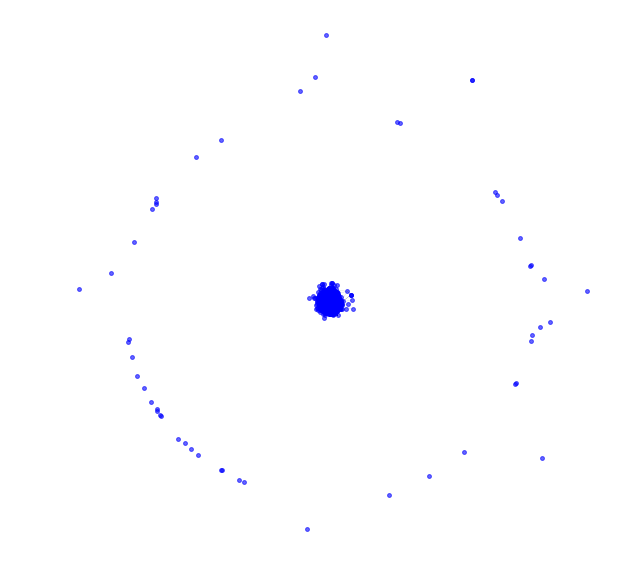

In [15]:
plt.figure(figsize=(10,10))
nx.draw_networkx(g, positions_g, 
                 width = 0.1, 
                 alpha=0.6, 
                 cmap=plt.get_cmap('jet'),
                 node_color='blue',
                 node_size=15, 
                 edge_size=90, with_labels=False)
plt.axis('off')
plt.show()

<div class="alert alert-block alert-info">
Nodes are clustered towards the center with very few nodes at the outer bounds of the network. The nodes outside of the centre clusters are the users that do not have watched any common movies with any other users. We will look at the number of connected components in the graph and look at their respective degree distributions.
</div>

In [16]:
cc = nx.number_connected_components(g)
print("There are %d connected components in the review network." %cc)

There are 53 connected components in the review network.


In [17]:
biggest_5_cc = sorted(nx.connected_component_subgraphs(g), key=lambda x:len(x), reverse=True)[:6]
for c in range(len(biggest_5_cc)):
    print("%d's biggest connected component's average shortest path: %.4f." %(c+1, 
                                                                              nx.average_shortest_path_length(biggest_5_cc[c])))

1's biggest connected component's average shortest path: 1.9575.
2's biggest connected component's average shortest path: 1.0000.
3's biggest connected component's average shortest path: 0.0000.
4's biggest connected component's average shortest path: 0.0000.
5's biggest connected component's average shortest path: 0.0000.
6's biggest connected component's average shortest path: 0.0000.


<div class="alert alert-block alert-info">
The results shows a drastic decrease in the length of the average shortest paths. This imply that the network is not truly connected together since the average shortest paths decreases as the size of the connected component decreases as well. One would expect that the value would stay the same if the network was connected. The second largest connected component is just two nodes connected directly to each other while the rest are just nodes by itself. Hence, we will focus our analysis on the the most strongly connected component.
</div>

In [18]:
# we are using only those users which have connections with each other
largest_connected_component = sorted(nx.connected_component_subgraphs(g), key = lambda x:len(x))[-1]

In [19]:
# Visualisation of the largest center cluster
# finding positions of the nodes using force atlas algorithm
f2 = ForceAtlas2(
                # Behavior alternatives
                outboundAttractionDistribution=False,  # Dissuade hubs
                edgeWeightInfluence=1.0,

                # Performance
                jitterTolerance=1.0,  # Tolerance
                barnesHutOptimize=True,
                barnesHutTheta=1.2,

                # Tuning
                scalingRatio=1300,
                strongGravityMode=False,
                gravity=0,

                # Log
                verbose=False)

positions_g_cc = f2.forceatlas2_networkx_layout(largest_connected_component, pos=None, iterations=2000)

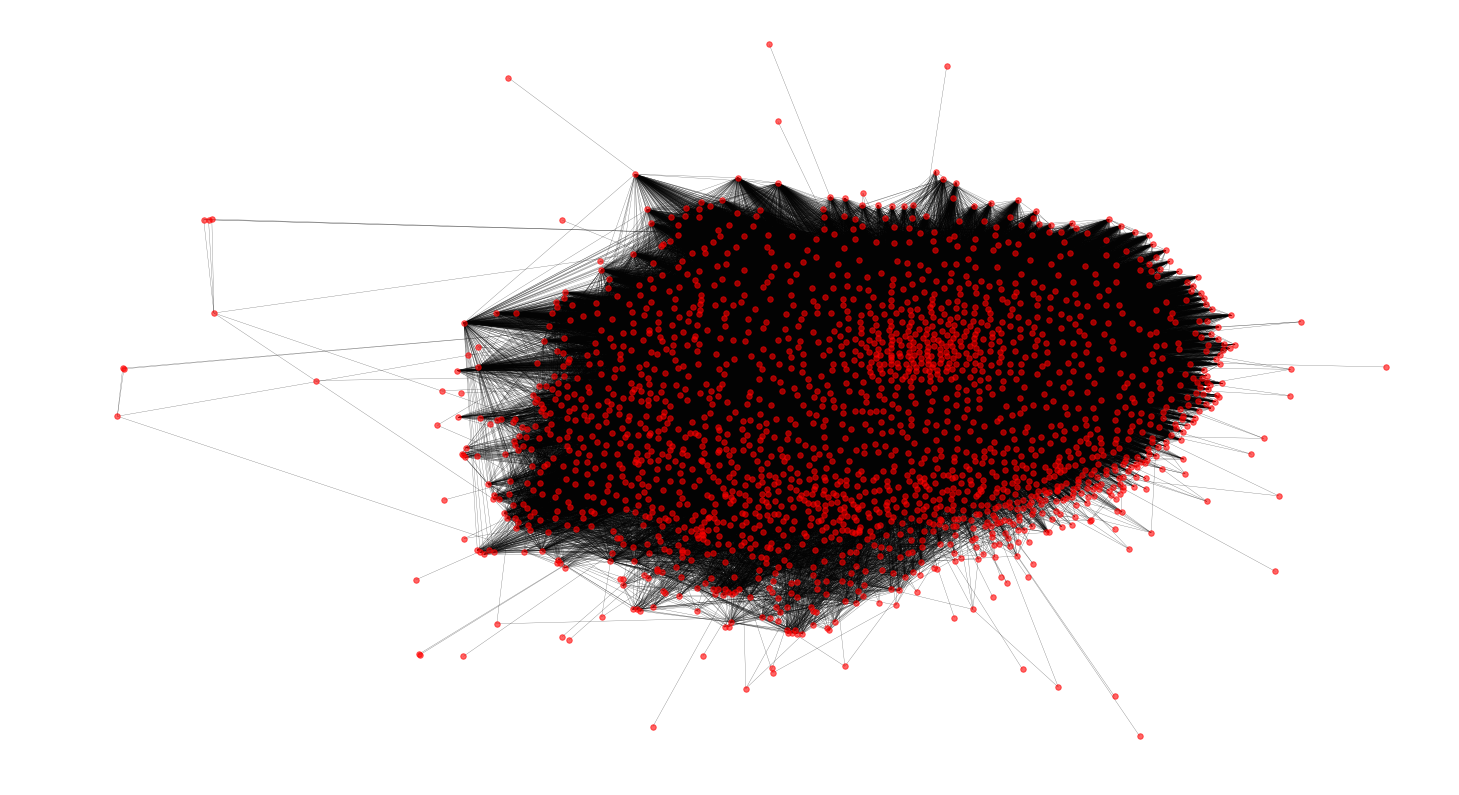

In [20]:
plt.figure(figsize=(25,14))
nx.draw_networkx(largest_connected_component, 
                 positions_g_cc, 
                 width = 0.3, 
                 alpha=0.6, 
                 cmap=plt.get_cmap('jet'), 
                 node_size=30, 
                 edge_size=90, 
                 with_labels=False)
plt.axis('off')
plt.show()

<div class="alert alert-block alert-info">
As expected, the central cluster has nodes which are all connected to each other. We are interested to find out whether there are hubs that could be formed in the connected component. These hubs could be communities of users that share similar characteristics while being distinguishingly different from other communities.
</div>

## 3.2 Network Attributes

### 3.2.1 Number of nodes, Number of edges, Average degrees


In [21]:
print(nx.info(largest_connected_component))

Name: 
Type: Graph
Number of nodes: 2003
Number of edges: 232910
Average degree: 232.5612


### 3.2.2 Degree distribution

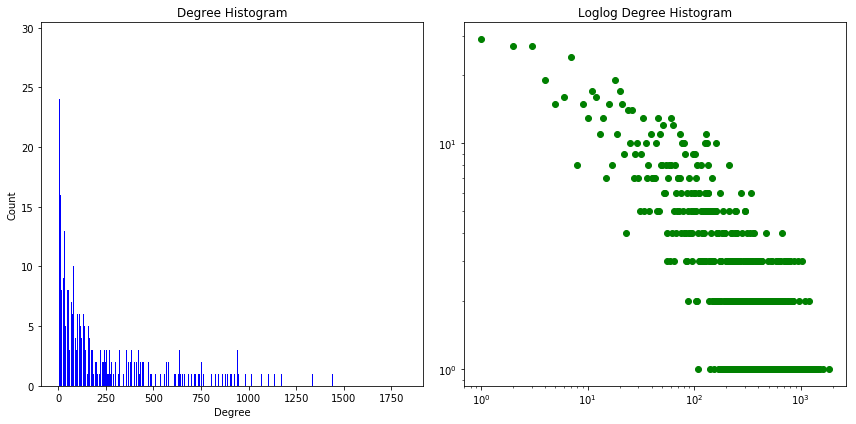

In [22]:
degree_sequence = sorted([d for n, d in largest_connected_component.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

plt.subplot(1,2,2)
plt.loglog(deg, cnt, color='g', linestyle='None', marker='o') # resembles power law
plt.title('Loglog Degree Histogram')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
As seen from the loglog plot, the general shape of the degree distribution of our movie review network follows a power law, where a large number of nodes have small connections and a small number of nodes have large connections.
</div>

### 3.2.3 Centralities Measures

#### 3.2.3.1 Top 3 Nodes with Highest degrees 

In [23]:
degree = list(largest_connected_component.degree())
degree = sorted(degree,key=lambda x:x[1], reverse=True)

x = PrettyTable()

x.field_names = ["UserId", "Number of degree"]

for i in degree[0:3]:
    x.add_row([i[0], i[1]])

print(x)

# print("The top 3 nodes with the highest degree along with their amount are:\n",degree[:3])

+--------+------------------+
| UserId | Number of degree |
+--------+------------------+
| 81924  |       1827       |
| 233632 |       1599       |
| 69860  |       1514       |
+--------+------------------+


#### 3.2.3.2 Top 3 Nodes with Highest Degree Centrality

>  Degree centrality is the most basic method of defining centrality, basing the centrality only on the number of neighbours a node has.

In [24]:
deg_cent = nx.degree_centrality(largest_connected_component)
deg_cent = sorted(deg_cent.items(), key=lambda x:x[1], reverse=True)

x = PrettyTable()

x.field_names = ["UserId", "Degree centrality"]

for i in deg_cent[0:3]:
    x.add_row([i[0], i[1]])
    
print(x)
# print("The top 3 nodes with the highest degree centrality are:\n", deg_cent[0], "\n", deg_cent[1] , "\n" , deg_cent[2])

+--------+--------------------+
| UserId | Degree centrality  |
+--------+--------------------+
| 81924  | 0.9125874125874126 |
| 233632 | 0.7987012987012987 |
| 69860  | 0.7562437562437563 |
+--------+--------------------+


<div class="alert alert-block alert-info">
The top degree centrality is rather high this suggests they are highly connected to other nodes in the network. Thus, these nodes are most likely to be clustered in the center of the network.
</div>

#### 3.2.3.3 Top 3 Nodes with Highest Betweeness Centrality

> Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes.

In [25]:
betweeness = nx.betweenness_centrality(g)

In [26]:
betweeness_sorted = sorted(betweeness.items(), key=lambda x:x[1], reverse=True)

x = PrettyTable()

x.field_names = ["UserId", "Betweeness centrality"]

for i in betweeness_sorted[0:3]:
    x.add_row([i[0], i[1]])
    
print(x)

# print(betweeness_sorted[0], "\n", betweeness_sorted[1] , "\n" , betweeness_sorted[2])

+--------+-----------------------+
| UserId | Betweeness centrality |
+--------+-----------------------+
| 81924  |  0.08480222837203834  |
| 233632 |  0.03879011381731195  |
| 69860  |  0.02706222553284114  |
+--------+-----------------------+


<div class="alert alert-block alert-info">
The max value is 0.085 which is close to zero. Small betweenness centrality means users are generally connected directly to each other as there are very few times that the node is acting as a bridge.
</div>

#### 3.2.3.4 Top 3 Nodes with Hightest Eigenvector Centrality

> The eigenvector centrality thesis read: A node is important if it is linked to by other important nodes. It is a measure of the influence of a node in a network.

In [27]:
eigen = nx.eigenvector_centrality(g)
eigen_sorted = sorted(eigen.items(), key=lambda x:x[1], reverse=True)

x = PrettyTable()

x.field_names = ["UserId", "Eigenvector centrality"]

for i in eigen_sorted[0:3]:
    x.add_row([i[0], i[1]])
    
print(x)

# print(eigen_sorted[0], '\n', eigen_sorted[1], '\n', eigen_sorted[2])

+--------+------------------------+
| UserId | Eigenvector centrality |
+--------+------------------------+
| 81924  |  0.06192699109472043   |
| 233632 |   0.0610741862461092   |
| 69860  |  0.06015765571794687   |
+--------+------------------------+


<div class="alert alert-block alert-info">
The top eigenvector centrality scores are close to zero which implies that users do not have much influence on one another even though they are top ranked based on eigenvector centrality.
</div>

### 3.2.4 Average Shortest Path Distance

In [28]:
avgsp = nx.average_shortest_path_length(largest_connected_component)
print("The average shortest path in this network is", avgsp)

The average shortest path in this network is 1.9574773703580493


<div class="alert alert-block alert-info">
This implies that for every pair (user1, user2), there is usually at least `1` node in between user1 and user2. Within the same cluster, users tend to watch the same types of movies but with slight alteration in preferences.
</div>

<div class="alert alert-block alert-info">
**In the following sections we will be studying potential correlation in the network. We are interested to investigate the relationship between the active-ness of an user and his/her average ratings/reviews. This will be done through building 2 networks, one for ratings and one for reviews. In both network, the size of nodes will be the number of distinct movies this particular user has given ratings/reviews, while the colour will be the average ratings/reviews.**
</div>

## 3.3 Potential Correlation in Ratings Network

### 3.3.1 Overview of Datasets for Ratings Network

In [29]:
''''
## Network based on ratings
dataframe consist of the following columns: 
    1. userid 
    2. count of unique movies 
    3. average of ratings 

common number of movies watched = weight for edges
average rating score = size of each node
average rating score = color for node 
'''

# Network based on RATINGS
df_ratings = df_half.copy()
# drop all users with NA rating
df_ratings = df_ratings.dropna(subset=['rating_combined'])

In [30]:
df_ratings.head()

,userId,movieId,userId_movieId,rating_combined,tag_combined,timestamp_combined
0,82922,167780,82922167780,4.0,NaN,1.537945e+09
1,82922,53519,8292253519,4.0,NaN,1.537945e+09
2,280481,494,280481494,3.0,NaN,1.537945e+09
3,280481,2355,2804812355,3.0,NaN,1.537945e+09
4,280481,2294,2804812294,2.0,NaN,1.537945e+09


In [31]:
# get the average ratings of each user
# get number of movies watched by each user
count_of_ratings = df_ratings.groupby(['userId'], as_index=False).agg({"rating_combined":'mean', "movieId": 'count'})
count_of_ratings.columns = ['userId', 'average rating', 'movie count']

In [32]:
count_of_ratings.head()

,userId,average rating,movie count
0,198,5.000000,1
1,214,3.000000,1
2,449,2.750000,6
3,574,4.454545,11
4,687,4.500000,1


### 3.3.2 Network Building

In [33]:
# Due to the nature of our dataset, we are using Undirected graph
g_ratings = nx.Graph()

# Adding each unique users as nodes into graph
for row in count_of_ratings.values:
    g_ratings.add_node(row[0], total_movies_watched=row[2], average_rating_score=row[1])

In [34]:
# get the common movies which users have watched 
# grouped them by the movie IDs 
common_movie_list_ratings = df_ratings.groupby('movieId')['userId'].apply(list)

In [35]:
common_movie_list_ratings.head()

movieId
1    [280481, 22925, 81924, 121315, 60534, 6768, 98...
2    [100983, 280481, 81924, 184475, 238606, 256236...
3                                     [131687, 178977]
5    [81600, 81924, 22925, 8450, 13109, 145766, 438...
6    [22925, 81924, 121315, 135418, 157463, 219702,...
Name: userId, dtype: object

In [36]:
# get the edge weights -- number of movies which both users watched in common
edgelist = {}
for movie, users in common_movie_list_ratings.items():
    lst = users
    
    for i in range(len(lst)):
        for j in range(0, len(lst)):
            if lst[i] == lst[j]: 
                continue
            if lst[i] not in edgelist.keys():
                edgelist[lst[i]] = []
                edgelist[lst[i]].append(lst[j])
            else:
                edgelist[lst[i]].append(lst[j])

In [37]:
# add the edges with weights
# Since we have all the neighbors which current user is connected with, 
# we can use Counter and get the total count of those users respectively. 
for curr_user, neighbours in edgelist.items():
    weights = Counter(neighbours)
    
    for user, weight in weights.items():
        g_ratings.add_edge(curr_user, user, weight=weight)

In [38]:
# we are using only those users which have connections with each other
largest_connected_component_ratings = sorted(nx.connected_component_subgraphs(g_ratings), key = lambda x:len(x))[-1]

In [39]:
# ForceAtlas2 to make our networks look visually nice!
f2_ratings = ForceAtlas2(
                # Behavior alternatives
                outboundAttractionDistribution=False,  # Dissuade hubs
                edgeWeightInfluence=1.0,

                # Performance
                jitterTolerance=1.0,  # Tolerance
                barnesHutOptimize=True,
                barnesHutTheta=1.2,

                # Tuning
                scalingRatio=1500,
                strongGravityMode=False,
                gravity=0,

                # Log
                verbose=False)

positions_ratings = f2_ratings.forceatlas2_networkx_layout(largest_connected_component_ratings, pos=None, iterations=2000)

In [40]:
# pos_ratings=nx.spring_layout(g_ratings,k=0.3*1/sqrt(len(largest_connected_component_ratings), iterations=200 )

In [41]:
# set the size of each node to how many movies they have watched/reviewed
node_sizes_ratings = []
helper = dict(largest_connected_component_ratings.node(data=True))

for user, score in helper.items():
    node_sizes_ratings.append(score['total_movies_watched'])

In [42]:
# Assigning colors to nodes based on their average rating score
node_rating_scores = []
for user, score in helper.items():
    s = round(score['average_rating_score']*2)/2  # up to nearest 0.5 now, you can change to nearest 1
    node_rating_scores.append(s)
    
# assigning color based on groupings
from itertools import count
groups_ratings = sorted(set(node_rating_scores))
mapping = dict(zip(groups_ratings,count()))
nodes_ratings = largest_connected_component_ratings.nodes()
colors = [mapping[round(largest_connected_component_ratings.node[n]['average_rating_score']*2)/2] for n in nodes_ratings]

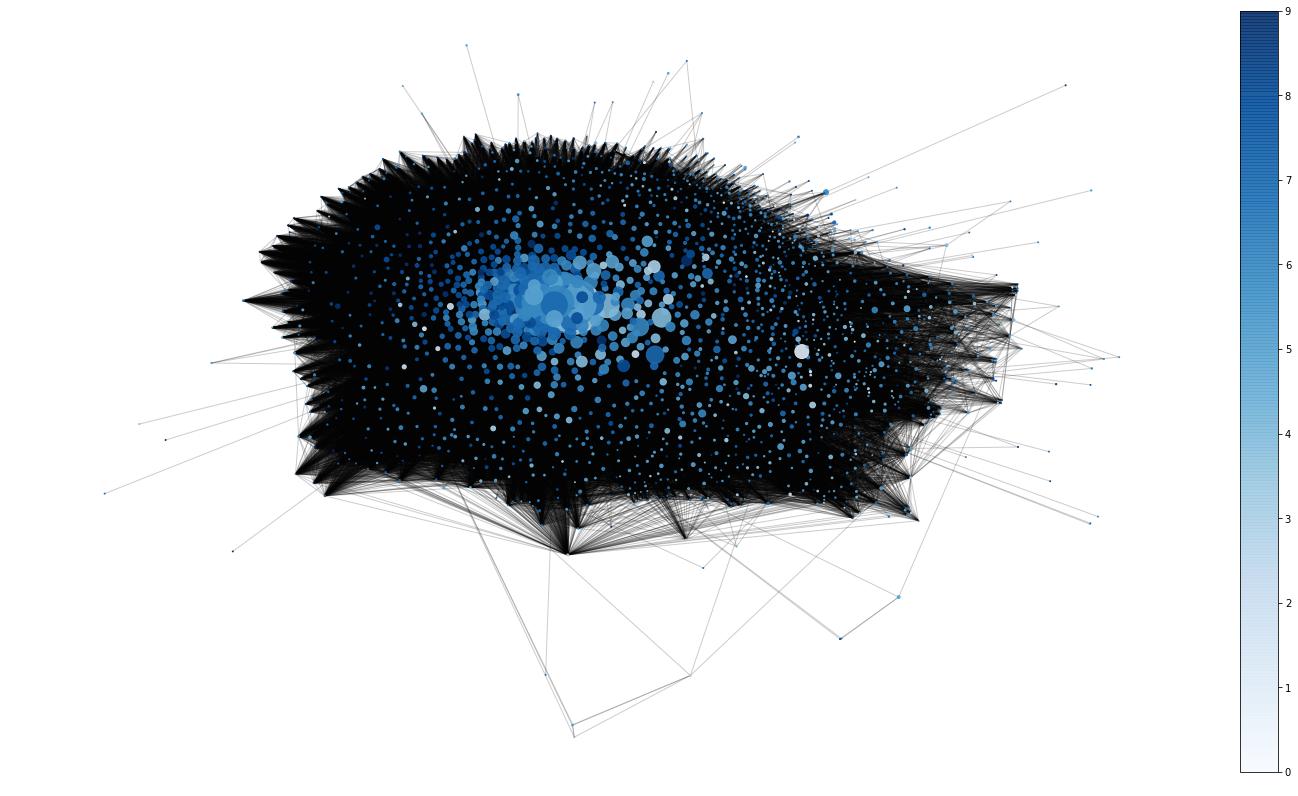

In [43]:
plt.figure(figsize=(25,14))
ec = nx.draw_networkx_edges(largest_connected_component_ratings,
                            positions_ratings, 
                            alpha=0.2)

nc = nx.draw_networkx_nodes(largest_connected_component_ratings,
                            positions_ratings, 
                            nodelist=largest_connected_component_ratings.nodes(), 
                            node_color=colors, 
                            with_labels=False, 
                            node_size=node_sizes_ratings, 
                            cmap=plt.cm.Blues,
                            alpha=0.9)

plt.colorbar(nc)
plt.axis('off')
plt.show()

<div class="alert alert-block alert-info">
As mentioned before, the node size represents the number of movie a user has watched. The color gradient represent the average rating score which each user gives. The higher the rating score, the darker the color.
<br>
As the network is pretty dense, it is hard to deduct the relationship between the number of movies an user has watched and the avaerage ratings the user gives. Thus, we will investigate the relationship further by using a scatter plot.
</div>

### 3.3.3 Scatter Plot

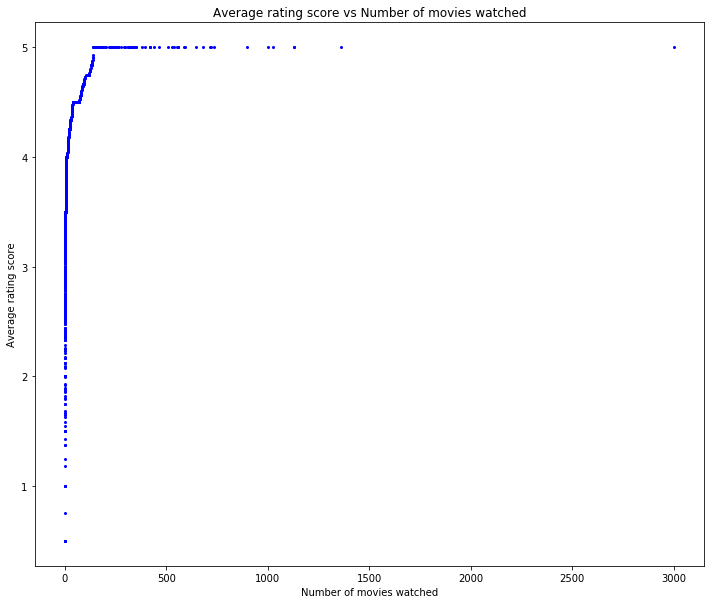

In [44]:
# Scatter plot for number of movies watched vs average rating score
x = sorted(nx.get_node_attributes(largest_connected_component_ratings, 'total_movies_watched').values())
y = sorted(nx.get_node_attributes(largest_connected_component_ratings, 'average_rating_score').values())

fig1 = plt.figure(figsize=(12,10))

ax2 = fig1.add_subplot(1,1,1)
# ax2.semilogy(x, y, marker='o', markersize=3, linestyle="None")
ax2.scatter(x,
            y, 
            color='blue',
           s=4)
ax2.set_title('Average rating score vs Number of movies watched')
ax2.set_xlabel("Number of movies watched")
ax2.set_ylabel("Average rating score")

plt.show()

<div class="alert alert-block alert-info">
The scatter plot can be roughly divided into 3 sections, the vertical line at the front, slanted line with steep graident in the middle and horizontal line at the end. Both vertical line and horizontal line suggest there is no correlation between the acive-ness of an user and the average ratings he/she gives, while the steep gradient for the slanted line indicates weak correlation. However, the percentage of points fall in the middle section (slanted line with steep gradient) is rather small compared to other 2 sections. Thus, we would conclude there is very weak correlation between the active-ness of an user and the average ratings he/she gives.
</div>

## 3.4 Potential Correlation in Reviews Network

### 3.4.1 Calculate Sentiment Scores

In [52]:
# happiness index 
S1 = pd.read_csv('Data_Set_S1.txt',encoding='utf-8', sep='\t')

# function to calculate sentiment scores
def cal_sentiment(lst):
    # create a word count dictionary to keep track of the frequency of the words
    word_count = {}
    all_count = Counter(lst)
    
    for i in set(lst):
        if i in list(S1["word"]):
            word_count[i] = all_count[i]
    
    # computation for the sentiment score based on the formula
    total_freq = sum(list(word_count.values()))
    result = 0
    for word in word_count.keys():
        p = word_count[word]/total_freq
        h = float(S1[S1["word"] == word]["happiness_average"])
        result += p*h
    
    return result

In [53]:
'''
## Network based on tags
dataframe consist of the following columns: 
    1. userid 
    2. count of unique movies 
    3. average sendimental scores of each user
common number of movies watched = weight for edges
avg review score = size of node 
avg review score = color for node 
'''
# Network based on REVIEWS(tags)
df_reviews = df_half.copy()
# drop all users with NA tags
df_reviews = df_reviews.dropna(subset=['tag_combined'])

In [54]:
df_reviews.head()

,userId,movieId,userId_movieId,rating_combined,tag_combined,timestamp_combined
12,243095,188797,243095188797,3.5,"{blasphemous, foul language, good stunts, grou...",1.537945e+09
18,243095,140956,243095140956,4.0,"{80s video games, action, adventure, avatars, ...",1.537945e+09
20,243095,192537,243095192537,4.0,"{documentary, nutrition, vitamins}",1.537945e+09
23,243095,189099,243095189099,3.0,"{dogs, funny, kids, pets, police dog, undercover}",1.537945e+09
47,243095,193243,243095193243,3.5,"{animation, foul language, kids, robot, swearing}",1.537944e+09


In [55]:
# get the average ratings of each user
# get number of movies watched by each user
count_of_reviews = df_reviews.groupby(['userId'], as_index=False).agg({"tag_combined":lambda x: ', '.join(x).replace('{', '').replace('}','').split(','), "movieId": 'count'})
count_of_reviews.columns = ['userId', 'tags', 'movie count'] 

In [56]:
count_of_reviews.head()

,userId,tags,movie count
0,449,"[John Cusack, Matthew McConaughey, Zac Efron...",3
1,574,[Realistic],1
2,1318,[horror-noir],1
3,2294,"[symbolic, Parent-child relationships, reven...",8
4,3298,"[Sad, touching]",1


In [57]:
# clean up the tags, make it ready for sentiment analysis later 
# create a user-tag-clean dictionary 
# key: user id
# values: list of non-NA tags with no punctuation, no capital letter or stopwords

user_tag_clean = {}
stopwords_list = stopwords.words("english")

for record in count_of_reviews.values:
    user_tag_clean[record[0]] = [] 
    tags = record[1]
    tags = [j.lower() for j in tags]
    tags = [j.replace('-','') for j in tags]
    tags = [j for j in tags if j not in stopwords_list]
    user_tag_clean[record[0]]+= tags
            

In [58]:
# calculate the sentiment of tags that a user has given 
# user-sentiment dictionary 
# key: user id 
# value: sentiment scores

user_sentiment = {}

for user, tags in user_tag_clean.items():
    user_sentiment[user] = cal_sentiment(tags)

In [59]:
df_user_sentiment = pd.DataFrame([user_sentiment]).T

df_user_sentiment.reset_index(inplace=True)
df_user_sentiment.columns = ['userId', 'sentiment score']
df_user_sentiment.head()

,userId,sentiment score
0,449,0.00
1,574,0.00
2,1318,0.00
3,2294,5.74
4,3298,2.38


In [60]:
# IMPORTANT
# need to join sendimental scores to table^
count_of_reviews_with_sentiments = pd.merge(count_of_reviews, df_user_sentiment, on=['userId'])

In [61]:
count_of_reviews_with_sentiments.head()

,userId,tags,movie count,sentiment score
0,449,"[John Cusack, Matthew McConaughey, Zac Efron...",3,0.00
1,574,[Realistic],1,0.00
2,1318,[horror-noir],1,0.00
3,2294,"[symbolic, Parent-child relationships, reven...",8,5.74
4,3298,"[Sad, touching]",1,2.38


### 3.4.2 Network Building

In [62]:
# Due to the nature of our dataset, we are using Undirected graph
g_reviews = nx.Graph()

# Adding each unique users as nodes into graph
for row in count_of_reviews_with_sentiments.values:
    g_reviews.add_node(row[0], total_movies_watched=row[2], average_sendimental_score=row[3])

In [63]:
# get the common movies which users have watched 
# grouped them by the movie IDs 
common_movie_list_reviews = df_reviews.groupby('movieId')['userId'].apply(list)

In [64]:
common_movie_list_reviews.tail()

movieId
193761    [156190]
193811    [128610]
193837    [245857]
193864    [148529]
193868     [74447]
Name: userId, dtype: object

In [65]:
# get the edge weights -- number of movies which both users watched in common
# key = userId
# value = list of users which current user and him has watched the same movie
edgelist = {}
for movie, users in common_movie_list_reviews.items():
    lst = users
    
    for i in range(len(lst)):
        for j in range(0, len(lst)):
            if lst[i] == lst[j]: 
                continue
            if lst[i] not in edgelist.keys(): # initiate a list for current user if he is not inside
                edgelist[lst[i]] = []
                edgelist[lst[i]].append(lst[j])
            else:
                edgelist[lst[i]].append(lst[j]) # append neighbour to list 

In [66]:
# add the edges with weights
# Since we have all the neighbors which current user is connected with, 
# we can use Counter and get the total count of those users respectively. 
for curr_user, neighbours in edgelist.items():
    weights = Counter(neighbours)
    
    for user, count in weights.items():
        # add edge between 2 users with the count as weight
        g_reviews.add_edge(curr_user, user, weight=count)

In [67]:
# we are using only those users which have connections with each other
largest_connected_component_reviews = sorted(nx.connected_component_subgraphs(g_reviews), key = lambda x:len(x))[-1]

In [68]:
# ForceAtlas2 to make our networks look visually nice!
f2_reviews = ForceAtlas2(
                # Behavior alternatives
                outboundAttractionDistribution=False,  # Dissuade hubs
                edgeWeightInfluence=1.0,

                # Performance
                jitterTolerance=1.0,  # Tolerance
                barnesHutOptimize=True,
                barnesHutTheta=1.2,

                # Tuning
                scalingRatio=900,
                strongGravityMode=False,
                gravity=0,

                # Log
                verbose=False)

positions_reviews = f2_reviews.forceatlas2_networkx_layout(largest_connected_component_reviews, pos=None, iterations=2000)

In [69]:
# set the size of each node to how many movies they have watched/reviewed
node_sizes_reviews = []
helper = dict(largest_connected_component_reviews.node(data=True))

for user, score in helper.items():
    node_sizes_reviews.append(score['total_movies_watched']*50)

In [70]:
# Assigning colors to nodes based on their average sentimental score
node_review_scores = []
for user, score in helper.items():
    s = round(score['average_sendimental_score']*2)/2  # up to nearest 0.5 now, you can change to nearest 1
    node_review_scores.append(s)
    
# assigning color based on groupings
from itertools import count
group_reviews = sorted(set(node_review_scores))
mapping_reviews = dict(zip(group_reviews,count()))
nodes_reviews = largest_connected_component_reviews.nodes()
color_reviews = [mapping_reviews[round(largest_connected_component_reviews.node[n]['average_sendimental_score']*2)/2] 
                 for n in nodes_reviews]

C:\Users\kianh\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


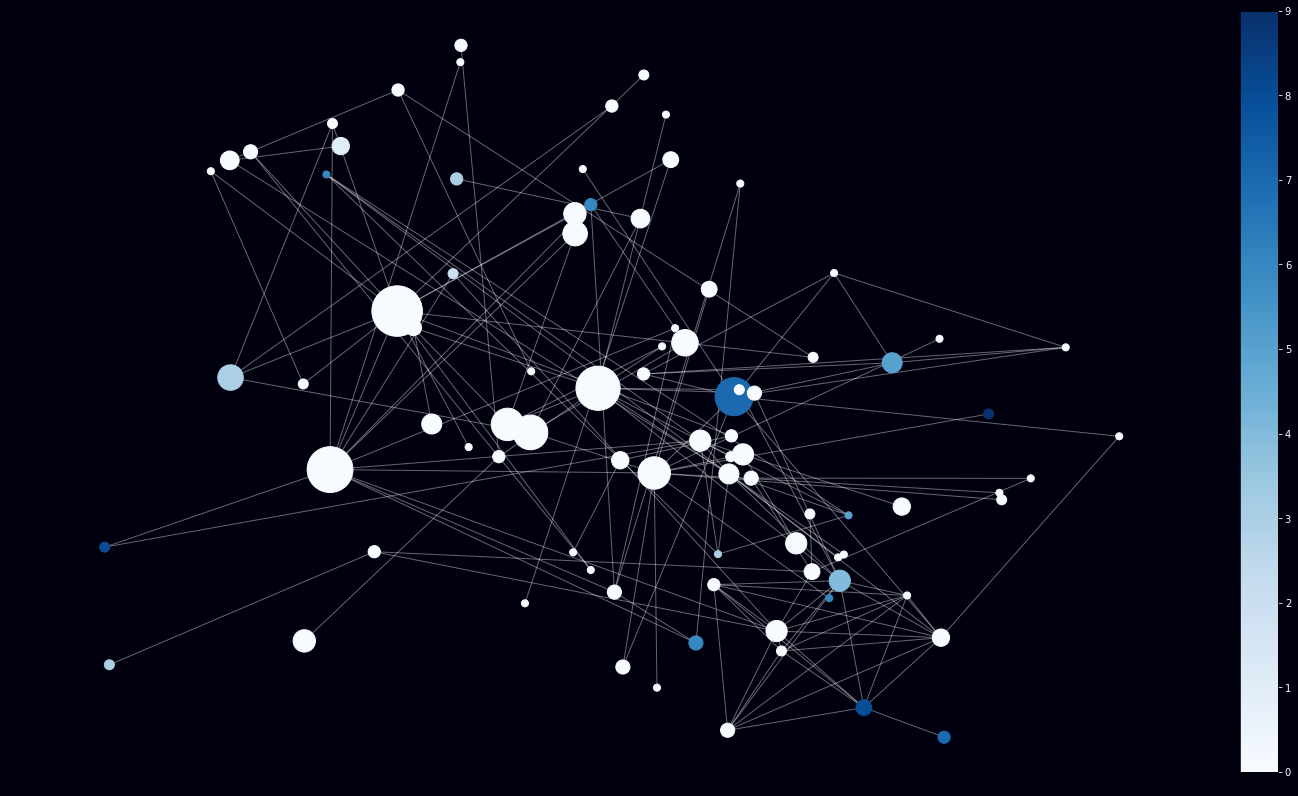

In [71]:
fig = plt.figure(figsize=(25,14))
ec = nx.draw_networkx_edges(largest_connected_component_reviews,
                            positions_ratings, 
                            alpha=0.4,
                           edge_color='white')

nc = nx.draw_networkx_nodes(largest_connected_component_reviews, 
                            positions_ratings, 
                            nodelist=largest_connected_component_reviews.nodes(), 
                            node_color=color_reviews, 
                            with_labels=False, 
                            node_size=node_sizes_reviews, 
                            cmap=plt.cm.Blues)

fig.set_facecolor("#00000F")
cb = fig.colorbar(nc)
# set colorbar tick color
cb.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')

plt.axis('off')
fig.show()

__Similar to the *ratings network (Section 3.1)*, users who have watched a larger number of movies has a larger sized node and users who have a higher average sentimental score are darker in color.__

__From the network, we see that there are majority of users have low sentimental scores. They also tend to have watched a higher number of movies compared to those with high sentimental scores. This could be due to such users having a higher expectation of movies since they have watched good movies which have left a benchmark on how a good movie should be like. This is quite similar to our finding back in our *ratings network*.__

### 3.4.3 Scatter Plot

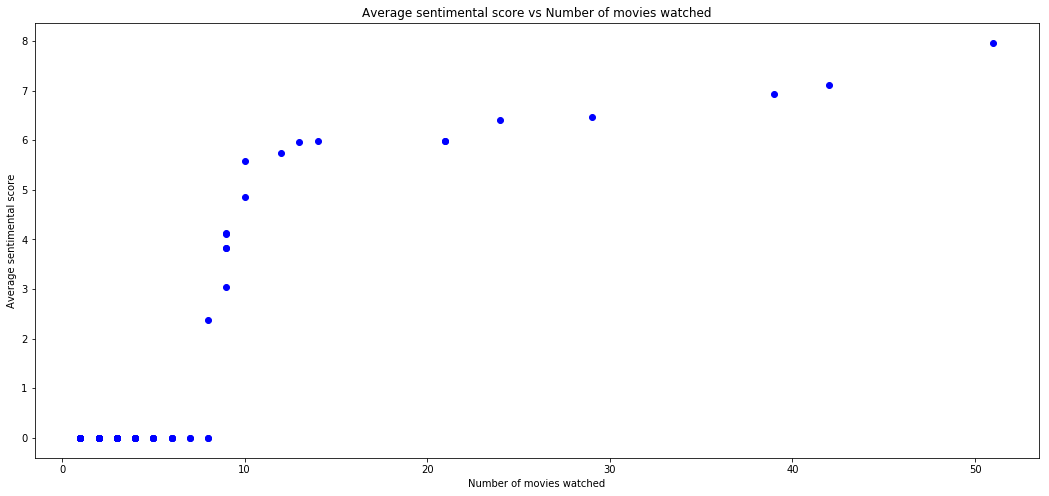

In [72]:
# Scatter plot for number of movies watched vs average rating score
x = sorted(nx.get_node_attributes(largest_connected_component_reviews, 'total_movies_watched').values())
y = sorted(nx.get_node_attributes(largest_connected_component_reviews, 'average_sendimental_score').values())

fig1 = plt.figure(figsize=(18,8))
ax2 = fig1.add_subplot(1,1,1)
ax2.scatter(x,
            y, 
            color='blue')
ax2.set_title('Average sentimental score vs Number of movies watched')
ax2.set_xlabel("Number of movies watched")
ax2.set_ylabel("Average sentimental score")

plt.show()

# 4. Community Detection

In [206]:
# https://perso.crans.org/aynaud/communities/index.html
communities_generator = community.best_partition(largest_connected_component)
values = [communities_generator.get(node) for node in largest_connected_component.nodes()]

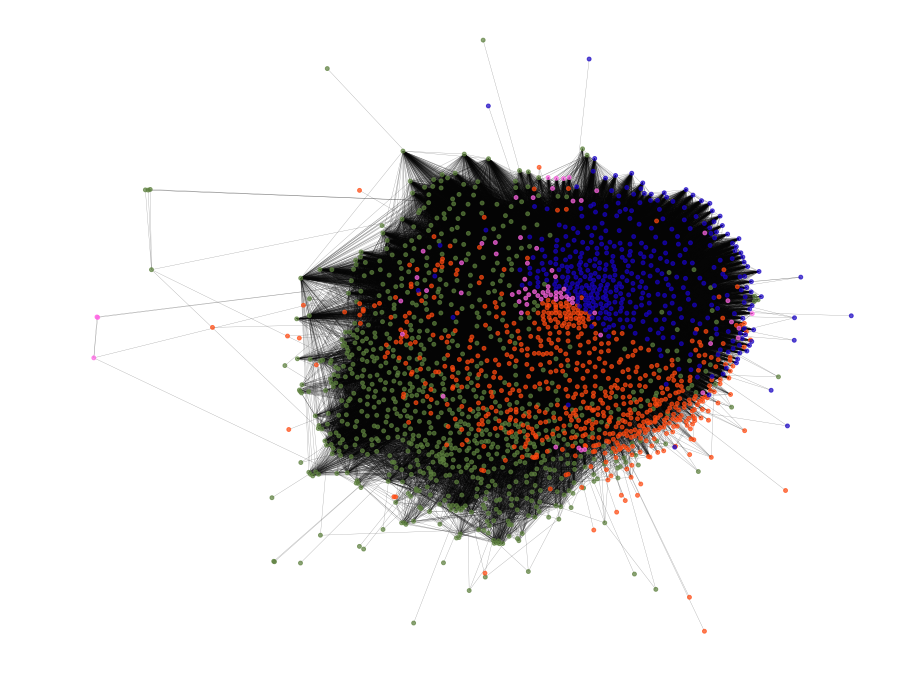

In [74]:
size = float(len(set(communities_generator.values())))
pos = nx.spring_layout(largest_connected_component)
count = 0

plt.figure(figsize=(15,12))

for com in set(communities_generator.values()) :
    count = count + 1.
    c = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    color = []
    
    # get all the nodes belonging to a community 
    list_nodes = [nodes for nodes in communities_generator.keys()
                                if communities_generator[nodes] == com]
    
    for n in list_nodes: # color generator
        color.append(c)
        
    nx.draw_networkx_nodes(largest_connected_component, positions_g_cc, list_nodes, node_size = 15, alpha=0.7,
                                node_color=color)


nx.draw_networkx_edges(largest_connected_component,positions_g_cc, alpha=0.4, width=0.3)

plt.axis('off')
plt.show()

In [75]:
print("The number of communities in our review network %d." %size)

The number of communities in our review network 4.


<div class="alert alert-block alert-info">
Using python's Louvain community detection algorithm to identifiy communities in a graph, we found that there are `4` communities hidding in our network. While this is a rather dense network , the nodes belong to the same community are closely clustered together. However, it is hard to assess the clear distinction between different communities. In the following section, we will move on to explore more about the common traits and distinct characteristics of each section. 
</div>

In [207]:
# group userIds according to their assigned community
nodes_in_coms = {}

for com in set(communities_generator.values()) :
    
    # get all the nodes belonging to a community 
    list_nodes = [nodes for nodes in communities_generator.keys() if communities_generator[nodes] == com]
    nodes_in_coms[com] = list_nodes

# 5. Investigation on Characteristics among Communities

We have obtained four communities from the previous section. Now we would like to study further on how  the communities are formed and what the distinct characteristics of each community are.

## 5.1 Average Ratings among Communities

<div class="alert alert-block alert-info">
In this section we would like to determine if the communities are split by their average ratings.
</div>

In [77]:
com1_avg_ratings = []
com2_avg_ratings = []
com3_avg_ratings = []
com4_avg_ratings = []

for com, users in nodes_in_coms.items():
    for user in users:
        avg = np.mean(df_half.loc[df_half['userId'] == user]['rating_combined'])
        if com == 1:
            com1_avg_ratings.append(avg)
        elif com == 2:
            com2_avg_ratings.append(avg)
        elif com == 3:
            com3_avg_ratings.append(avg)
        else: 
            com4_avg_ratings.append(avg)


In [78]:
com1_pcent = []
print("There are %d users in community one." %len(com1_avg_ratings))
for rating, users in Counter(com1_avg_ratings).items():
    res = float(users)/len(com1_avg_ratings)*100
    com1_pcent.append((round(rating, 1), round(res,2)))
#     print("Users with %.1f ratings make up %.2f percent of community 1." %(rating,res))
com1_pcent = sorted(com1_pcent, key=lambda x:x[1], reverse=True)
print(com1_pcent[:5])
print('\n' + '*'*100 + '\n')

com2_pcent = []
print("There are %d users in community two." %len(com2_avg_ratings))
for rating, users in Counter(com2_avg_ratings).items():
    res = float(users)/len(com2_avg_ratings)*100
    com2_pcent.append((round(rating, 1), round(res,2)))
#     print("Users with %.1f ratings make up %.2f percent of community 2." %(rating,res))
com2_pcent = sorted(com2_pcent, key=lambda x:x[1], reverse=True)
print(com2_pcent[:5])
print('\n' + '*'*100 + '\n')

com3_pcent = []
print("There are %d users in community three." %len(com3_avg_ratings))
for rating, users in Counter(com3_avg_ratings).items():
    res = float(users)/len(com3_avg_ratings)*100
    com3_pcent.append((round(rating, 1), round(res,2)))
#     print("Users with %.1f ratings make up %.2f percent of community 3." %(rating,res))
com3_pcent = sorted(com3_pcent, key=lambda x:x[1], reverse=True)
print(com3_pcent[:5])
print('\n' + '*'*100 + '\n')

com4_pcent = []
print("There are %d users in community three." %len(com4_avg_ratings))
for rating, users in Counter(com4_avg_ratings).items():
    res = float(users)/len(com4_avg_ratings)*100
    com4_pcent.append((round(rating, 1), round(res,2)))
#     print("Users with %.1f ratings make up %.2f percent of community 3." %(rating,res))
com4_pcent = sorted(com4_pcent, key=lambda x:x[1], reverse=True)
print(com4_pcent[:5])

There are 659 users in community one.
[(3.5, 9.41), (4.0, 7.89), (4.5, 5.16), (3.0, 4.7), (5.0, 3.95)]

****************************************************************************************************

There are 407 users in community two.
[(5.0, 8.35), (4.0, 6.63), (4.5, 6.14), (3.5, 2.7), (4.8, 2.21)]

****************************************************************************************************

There are 70 users in community three.
[(4.0, 11.43), (3.5, 8.57), (3.0, 4.29), (4.5, 4.29), (5.0, 2.86)]

****************************************************************************************************

There are 867 users in community three.
[(4.0, 10.03), (3.5, 9.8), (3.0, 4.96), (4.5, 4.61), (5.0, 3.23)]


<div class="alert alert-block alert-info">
If they are splited by average rating, the majority of the users in each community should have the corresponding average rating. However, looking at the top 5 rating groups of each community, they are less than 10% of their respective population. Hence, we would like to conclude that the communities are not split by the average ratings given by users.


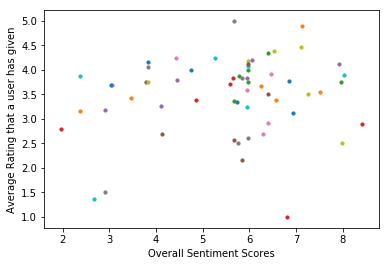

In [79]:
# average rating of each user
user_rating = df_half.groupby(['userId']).mean()['rating_combined']
# scatter plot for sentiment score vs average rating 
# no obvious pattern found 
for user in user_sentiment:
    if user_sentiment[user] !=0:
        plt.scatter(user_sentiment[user],user_rating[user], s=10)
#plt.title("Sentiment score VS Number of Tags")
plt.ylabel ('Average Rating that a user has given')
plt.xlabel ('Overall Sentiment Scores')
plt.show()

<div class="alert alert-block alert-info">
The above is the scatter plot of Average Rating VS Sentiment Score given by each user. We do not observe any obvious pattern in the plot, which suggests that there is no direct correlation between the average rating and sentiment score. Therefore, sentiment scores given by users could be another possible factor which the community formation is basd on. In the next section, we will determine if this hypothesis is true.
<div>

## 5.2 Sentiment Scores among Communities

In [80]:
# happiness index 
S1 = pd.read_csv('Data_Set_S1.txt',encoding='utf-8', sep='\t')

In [81]:
# function to calculate the sentiment scores for a given list of text
def cal_sentiment(lst):
    # create a word count dictionary to keep track of the frequency of the words
    word_count = {}
    all_count = Counter(lst)
    
    for i in set(lst):
        if i in list(S1["word"]):
            word_count[i] = all_count[i]
    
    # computation for the sentiment score based on the formula
    total_freq = sum(list(word_count.values()))
    result = 0
    for word in word_count.keys():
        p = word_count[word]/total_freq
        h = float(S1[S1["word"] == word]["happiness_average"])
        result += p*h
    
    return result

In [82]:
# create user-movie dictionary 
# key: user id
# value: list of movies id that the user watched
user_movie = {}
for user in list(set(df_half['userId'])):
    if user not in user_movie:
        user_movie[user]=list(df_half[df_half['userId']==user]['movieId'])

In [83]:
# create user_tag dictionary 
# key: user id
# value: list of tags that the user has given
user_tag ={}
for user in list(set(df_half['userId'])):
    if user not in user_tag:
        user_tag[user]=list(df_half[df_half['userId']==user]['tag_combined'])
        
# too much NAs 

In [84]:
# create a new column 'tag_combined' which is the list of tags that a user has given to corresponding movie 
# all na values are dropped 
df_half2 = df_half.copy()
df_half2 = df_half2[pd.notnull(df_half2['tag_combined'])]

In [85]:
# create a user_tag dictionary with no NA values
user_tag_noNAN ={}
for user in list(set(df_half2['userId'])):
    if user not in user_tag_noNAN:
        user_tag_noNAN[user]=list(df_half2[df_half2['userId']==user]['tag_combined'])

In [86]:
# clean up the tags, make it ready for sentiment analysis later 
# create a user-tag-clean dictionary 
# key: user id
# values: list of non-NA tags with no punctuation, no capital letter or stopwords

user_tag_clean = {}
stopwords_list = stopwords.words("english")

for user in user_tag_noNAN:
    user_tag_clean[user]=[]
    for tags in user_tag_noNAN[user]:
        tags = tags[1:-1] # remove '{' and '}'
        tags = [i for i in tags.split(', ')]
        
        for tag in tags:
            tag = [j for j in tag.split(' ')]
            tag = [j.lower() for j in tag]
            tag = [j.replace('-','') for j in tag]
            tag = [j for j in tag if j not in stopwords_list]
            user_tag_clean[user]+= tag
            

In [87]:
# calculate the sentiment of tags that a user has given 
# user-sentiment dictionary 
# key: user id 
# value: sentiment scores

user_sentiment = {}

for user, tags in user_tag_clean.items():
    user_sentiment[user] = cal_sentiment(tags)

### 5.2.1 Distribution of Sentiment Scores

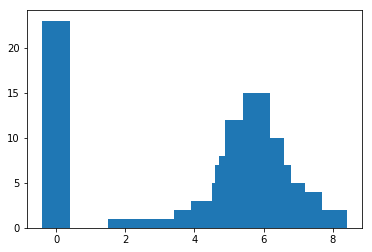

In [88]:
# distribution for sentiment scores 
# round the scores up to nearest 0.1
sentiment_scores = []
for i in user_sentiment.values():
    s = round(i,1)
    sentiment_scores.append(s)
    
sentiment_distribution = dict(Counter(sentiment_scores))
plt.bar(sentiment_distribution.keys(), sentiment_distribution.values())
plt.show()

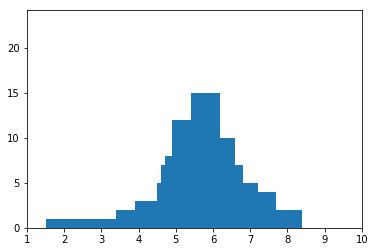

In [89]:
# remove sentiment scores which are 0 
plt.bar(sentiment_distribution.keys(), sentiment_distribution.values())
plt.xlim(1, 10)
plt.show()

<div class="alert alert-block alert-info">
Words with sentiment score of 0 are usually neutral or not included in the happiness index table. While we study the distribution of overall sentiment scores given by all users, we discard those of 0 sentiment score and find that the rest of the scores actually follow a normal distribution, with mean of 6, which is slightly positive. 

</div>

<div class="alert alert-block alert-info">
 Next, we will construct plots of sentiment score distribution for each community. If all of the four plots show similar distribution, it suggests that there is no significant difference in sentiment scores among different communities. The communities are thus not split based on the sentiment scores. 

### 5.2.2 Sentiment Score for each Community

In [208]:
# get user list for each community 
com1_users =  nodes_in_coms[0]
com2_users =  nodes_in_coms[1]
com3_users =  nodes_in_coms[2]
com4_users =  nodes_in_coms[3]

In [91]:
# dictionary that count the number of tags a user has given
# key: user id 
# value: total number of tags that a user has give
user_tag_count = {}
for user in user_tag_noNAN:
    
    count = 0
       
    for tags in user_tag_noNAN[user]:
        tags = tags[1:-1] # remove '{' and '}'
        tags = [i for i in tags.split(', ')]
        

        for tag in tags:
            count += 1 
    user_tag_count[user] = count

In [92]:
# function to create a dictionary for each community 
# key: user id
# value: list of movie ids that the user has watched
def user_watch_movies(user_list):
    output = {}
    for user in user_list:
        movies = list(df_half[df_half['userId']==user]['movieId'])
        output[user]=movies
    return output

In [93]:
# function to create a dictionary for each community 
# key: user id
# value: list of movie ids that the user has given tags about
def user_tag_movies(user_list):
    output = {}
    df_half2 = df_half[pd.notnull(df_half['tag_combined'])]
    for user in user_list:
        movies = list(df_half2[df_half2['userId']==user]['movieId'])
        output[user]=movies
    return output

In [94]:
# function to create a dictionary for each community 
# key: user id
# value: list of movie ids that the user has given tags about
def user_tag_movies(user_list):
    output = {}
    df_half2 = df_half[pd.notnull(df_half['tag_combined'])]
    for user in user_list:
        movies = list(df_half2[df_half2['userId']==user]['movieId'])
        output[user]=movies
    return output

In [95]:
# function to compute sentiment scores for the input user community
def com_sentiments(user_list):
    x = user_clean_tags(user_list)
    user_sentiment = {}
    for user, tags in x.items():
        user_sentiment[user] = round(cal_sentiment(tags)*2)/2
        
    return user_sentiment

In [216]:
# function to plot histogram for the sentiment scores of selected community
def sentiment_hist(sentiment_dic):
    scores = list(sentiment_dic.values())
    counts = Counter(scores)
    del counts[0]

    plt.bar(counts.keys(), counts.values(), width=0.2)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Number of Users', fontsize=13)
#     plt.xlim(1,10)
#     plt.ylim(1,10)
    plt.show()

In [97]:
# function to calculate average sentiment scores of a community
def avg_sentiment(sentiment_dic):
    non_zero = []
    for i in sentiment_dic.values():
        if i !=0:
            non_zero.append(i)
    return sum(non_zero)/ len(non_zero)

In [98]:
# tag cleanning function
# input: string
# output: string with punctuation removed inside the string
def remove_punch_within(word):
    punch = string.punctuation
    punch = punch + '…' + '–' + "’"
    table = str.maketrans({key: None for key in punch})
    new_s = word.translate(table)
    
    return new_s

# Not working
def extract_names(tag_lst): 
    print(tag_lst)
    for chunk in nltk.ne_chunk(nltk.pos_tag(tag_lst)):
        if hasattr(chunk, 'node'):
            print(chunk.node, ' '.join(c[0] for c in chunk.leaves()))

def clean_tags(tag_lst):
    content = tag_lst.replace("{", "")
    content = content.replace("}", "")
    
    # split to words in the list
    content = content.split()
    
    # remove the punctuation in the word
    content = [remove_punch_within(word) for word in content]
    
    # remove the punctuation in the list
    punch = string.punctuation
    punch = punch + '…' + '–' + "’"
    content = [word for word in content if word not in punch]
    
    # set lower case
    content = [word.lower() for word in content]
    
    # remove the stop words
    stopwords_list = stopwords.words("english")
    content = [word for word in content if word not in stopwords_list]
    
    # remvoe numbers
    content = [word for word in content if not word.isdigit()]
    
    # remove empty space
    content = [word for word in content if word]
    
    # remove names 
#     names = extract_names()
    
    return content

def user_clean_tags(user_list):
    
    # get all tags with no NaN
    df_half2 = df_half[pd.notnull(df_half['tag_combined'])]
    
    # get each user's tags from reviews table 
    user_tag_noNAN ={}
    for user in user_list:
        if user not in user_tag_noNAN:
            user_tag_noNAN[user]=list(df_half2[df_half2['userId']==user]['tag_combined'])
   
    user_tag_clean = {}
    stopwords_list = stopwords.words("english")

    for user in user_list:
        user_tag_clean[user]=[]
        for tags in user_tag_noNAN[user]:
            tags = clean_tags(tags) # replace with kh's clean function
            user_tag_clean[user] = tags
                
    return user_tag_clean

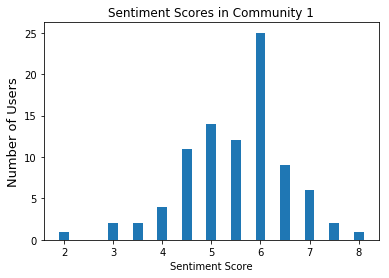

Average sentiment score is 5.51


In [217]:
# histogram for sentiment scores to nearest 0.5, disgarding those with score of 0
c1_scores = com_sentiments(com1_users)
plt.title("Sentiment Scores in Community 1")
sentiment_hist(c1_scores)
print("Average sentiment score is " + str(round(avg_sentiment(c1_scores),2)))

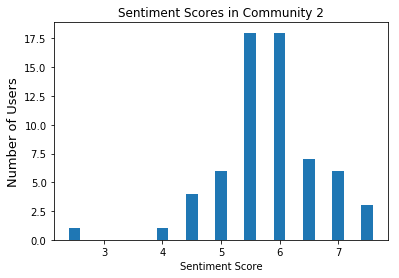

Average sentiment score is 5.8


In [218]:
c2_scores = com_sentiments(com2_users)
plt.title("Sentiment Scores in Community 2")
sentiment_hist(c2_scores)
print("Average sentiment score is " + str(round(avg_sentiment(c2_scores),2)))

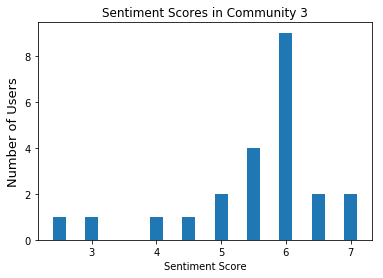

Average sentiment score is 5.52


In [219]:
c3_scores = com_sentiments(com3_users)
plt.title("Sentiment Scores in Community 3")
sentiment_hist(c3_scores)
print("Average sentiment score is " + str(round(avg_sentiment(c3_scores),2)))

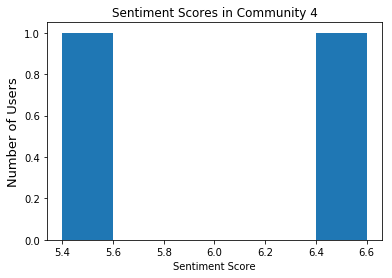

Average sentiment score is 6.0


In [220]:
c4_scores = com_sentiments(com4_users)
plt.title("Sentiment Scores in Community 4")
sentiment_hist(c4_scores)

print("Average sentiment score is " + str(round(avg_sentiment(c4_scores),2)))

<div class="alert alert-block alert-info">
The sentiment score distributions and the average sentiment scores appear to be similar for first three community groups. Community 4 could be considered as an outlier as there are only 70 users included and 2 users with non-zero sentiment scores. Thus, we would like conclude that the communities is not split based on sentiment scores. 
</div>

## 5.3 Text Analysis

### 5.3.1 Top Tags

- **Top 1 frequently used tags by all users**

In [103]:
# collect all the tags given by users
all_tags = []
for user in user_tag_clean:
    for tag in user_tag_clean[user]:
        all_tags.append(tag)
        
# count the number of occurrance of each tag 
tag_count = dict(Counter(all_tags))

# the most frequently used tag 
"The most frequently used tag by all users is '"  +max(tag_count.items(), key=operator.itemgetter(1))[0] + "'"

"The most frequently used tag by all users is 'comedy'"

- **Top 30 frequently used tags by all users**

In [104]:
# top 30 frequently used tags 
for i in sorted(tag_count, key=tag_count.get, reverse=True)[:30]:
    print(i)

comedy
atmospheric
dark
horror
based
scifi
ending
story
twist
bad
plot
visually
romance
book
action
space
great
film
war
nudity
appealing
predictable
true
acting
drama
dystopia
friendship
thriller
funny
humor


<div class="alert alert-block alert-info">
By examining the most frequent used tags, we see that users usually give tags which are genres or themes of the movies they watch, and these tags tend to be neutral. Thus, we can infer that the tags given by users are closely associated with the movies they have watched. This suggests the community may be defined by different genres of movies the user watch. In the following parts, we will study the behaviour of users in selecting movie genres in various communities. 
</div>

### 5.3.2 Wordcloud for each Community

<div class="alert alert-block alert-info">
After an overview of the content for the tags, we would like to zoom into each community to explore the common traits and different characteristics among the four communities.
</div>

In [105]:
### To be use in the next few sections...
# Create a dict for each community 
# consisting of each word as key, count of word as value
com1_taglist = []
com2_taglist = []
com3_taglist = []
com4_taglist = []

# process each community of users 
for com, users in nodes_in_coms.items():
    for user in users:
        # get the tags belonging to this user
        user_tags = df_half.loc[df_half['userId'] == user]['tag_combined']
        # drops all empty reviews
        user_tags = user_tags.dropna()
        
        # clean the tags belonging to a user 
        for user_tag in user_tags:
            cleaned_tag = clean_tags(user_tag)
            
            if com == 0:
                com1_taglist.extend(cleaned_tag)
            elif com == 1:
                com2_taglist.extend(cleaned_tag)
            elif com == 2:
                com3_taglist.extend(cleaned_tag)
            else:
                com4_taglist.extend(cleaned_tag)

# word : count of word in each cluster
com1_tagdict = dict(Counter(com1_taglist))
com2_tagdict = dict(Counter(com2_taglist))
com3_tagdict = dict(Counter(com3_taglist))
com4_tagdict = dict(Counter(com4_taglist))

- **Community 1**

__TF__

In [106]:
tfs_com1 = {}
totalword = sum(list(com1_tagdict.values()))

for word, count in com1_tagdict.items():
    tf = count/totalword
    tfs_com1[word] = tf 

__IDF__

In [107]:
idfs_com1 = {}
N = 4
n = 0

# process each tag in cluster x
# check how many times the tag appear in the other clusters 
for word in com1_tagdict.keys():
    if word in com2_tagdict.keys() and word in com3_tagdict.keys() and word in com4_tagdict.keys():
        n = 4
    elif word in com2_tagdict.keys() and word in com3_tagdict.keys():
        n = 3
    elif word in com2_tagdict.keys() and word in com4_tagdict.keys():
        n = 3
    elif word in com3_tagdict.keys() and word in com4_tagdict.keys():
        n = 3
    elif word in com2_tagdict.keys() or word in com3_tagdict.keys():
        n = 2
    elif word in com2_tagdict.keys() or word in com4_tagdict.keys():
        n = 2
    elif word in com3_tagdict.keys() or word in com4_tagdict.keys():
        n = 2
    else:
        n = 1
        
    idf = float(math.log2((N/n))) # apply the formula for IDF
    
    idfs_com1[word] = idf

__TF-IDF__

In [108]:
tfidf_com1 = {}

for word, tf in tfs_com1.items():
    tfidf =  tf * idfs_com1[word]
    tfidf_com1[word] = tfidf

In [109]:
com1_sorted_tags = sorted(tfidf_com1.items(), key=lambda x: x[1], reverse=True)
print("The top 10 most important tags in Community 1 are:\n")
com1_sorted_tags[0:10]

The top 10 most important tags in Community 1 are:



[('might', 0.009025270758122744),
 ('like', 0.009025270758122744),
 ('madrid', 0.008122743682310469),
 ('opera', 0.00631768953068592),
 ('heist', 0.00631768953068592),
 ('reviewed', 0.00631768953068592),
 ('lgbtq', 0.0058664259927797835),
 ('family', 0.005415162454873646),
 ('prospect', 0.005415162454873646),
 ('comedy', 0.005244156128072032)]

<div class="alert alert-block alert-info">
Looking at the top 10 most important tags ranked based on TF-IDF, the score obtained are rather small. Thus, we need to transform the TF-IDF score when feeding to the word cloud generation. This is done by times the original TF-IDF score with a factor of 1000. The rationale of choosing 1000 is due the max TF-IDF being 0.00903 (3 significant figures) and after the product we will obain 9.03 which will roughly allow us to transform the scale to 1-10.  Furthermore, the fact that the top 10 TF-IDF scores being small suggests, these tags are probably seen in other communities as well. It suggests there are common traints among the 4 communities identified.
</div>

__Word cloud__

In [184]:
com1_string = ""

for word, tfidf in tfidf_com1.items():
    for i in range(math.ceil(tfidf*1000)):
        com1_string = com1_string + word + ' '

# print(com1_string)

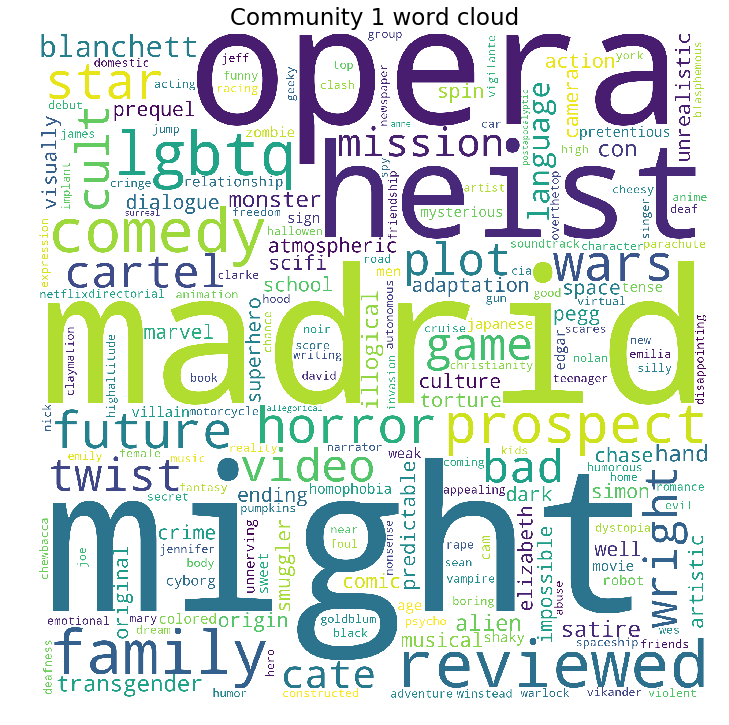

In [186]:
plt.figure(figsize=(12,26))
wordcloud_com1 = WordCloud(stopwords=STOPWORDS, 
                           width=2500, height=2500, 
                           background_color="white",
                           collocations=False).generate(com1_string)
img_com1 = plt.imshow(wordcloud_com1)
plt.axis("off")
plt.title("Community 1 word cloud", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
Words such as `might`, `opera`, `heist` and `madrid` defines community one as they are much bigger in size and can be easily notced in the word cloud. We also see words such as `comedy`, `horror`, `family` that describes genres of movies. This suggest that majority of community one users tend to watch such genres. 
</div>

- **Community 2**

__TF__

In [112]:
tfs_com2 = {}
totalword = sum(list(com2_tagdict.values()))

for word, count in com2_tagdict.items():
    tf = count/totalword
    tfs_com2[word] = tf   

__IDF__

In [113]:
idfs_com2 = {}
N = 4
n = 0

# process each tag in cluster x
# check how many times the tag appear in the other clusters 
for word in com2_tagdict.keys():
    if word in com1_tagdict.keys() and word in com3_tagdict.keys() and word in com4_tagdict.keys():
        n = 4
    elif word in com1_tagdict.keys() and word in com3_tagdict.keys():
        n = 3
    elif word in com1_tagdict.keys() and word in com4_tagdict.keys():
        n = 3
    elif word in com3_tagdict.keys() and word in com4_tagdict.keys():
        n = 3
    elif word in com1_tagdict.keys() or word in com3_tagdict.keys():
        n = 2
    elif word in com1_tagdict.keys() or word in com4_tagdict.keys():
        n = 2
    elif word in com3_tagdict.keys() or word in com4_tagdict.keys():
        n = 2
    else:
        n = 1
        
    idf = float(math.log2((N/n))) # apply the formula for IDF
    
    idfs_com2[word] = idf

__TF-IDF__

In [114]:
tfidf_com2 = {}

for word, tf in tfs_com2.items():
    tfidf =  tf * idfs_com2[word]
    tfidf_com2[word] = tfidf

In [115]:
com2_sorted_tags = sorted(tfidf_com2.items(), key=lambda x: x[1], reverse=True)
com2_sorted_tags[0:10]

[('low', 0.009263157894736843),
 ('fantasy', 0.006736842105263158),
 ('comedy', 0.005941589463360289),
 ('noir', 0.0054736842105263155),
 ('atmospheric', 0.005067826306983776),
 ('witch', 0.0050526315789473685),
 ('foreign', 0.0050526315789473685),
 ('studio', 0.004210526315789474),
 ('ghibli', 0.004210526315789474),
 ('slasher', 0.004210526315789474)]

__Word cloud__

In [187]:
com2_string = ""

for word, tfidf in tfidf_com2.items():
    for i in range(math.ceil(tfidf*1000)):
        com2_string = com2_string + word + ' '

# print(com2_string)

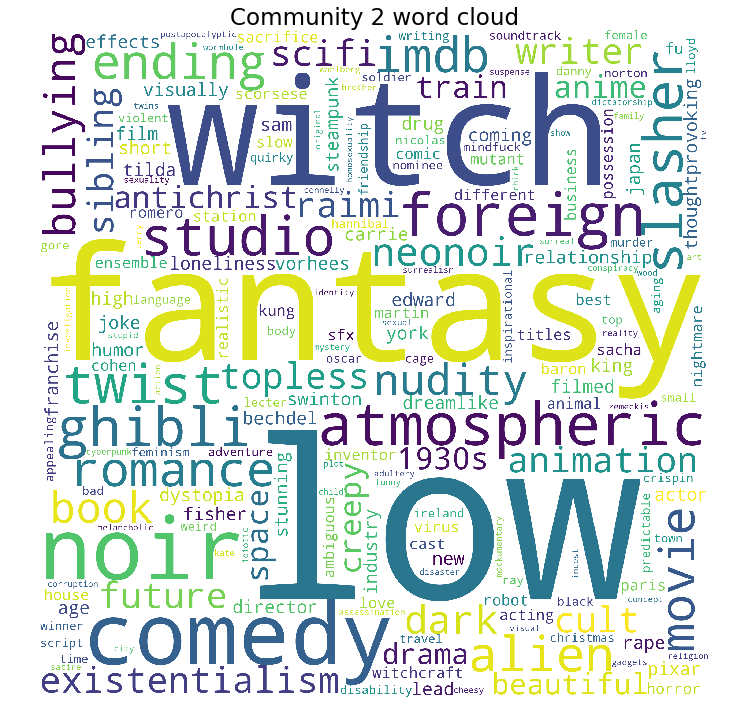

In [188]:
plt.figure(figsize=(12,14))
wordcloud_com2 = WordCloud(stopwords=STOPWORDS, 
                           width=2500, height=2500, 
                           background_color="white",
                           collocations=False).generate(com2_string)
img_com2 = plt.imshow(wordcloud_com2)
plt.axis("off")
plt.title("Community 2 word cloud", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
Words such as `witch`, `fantasy`, `comedy` defines community two. These words suggest that community two users tend to watch fairy tale, cartoonic genres of movies or movies that contain more imaginery elements. Furthermore, we also see words such as `ghibli`, `animation` and `foreign` which may also suggest they watch movies that are made in other countries such as Japan. 
</div>

- **Community 3**

__TF__

In [118]:
tfs_com3 = {}
totalword = sum(list(com3_tagdict.values()))

for word, count in com3_tagdict.items():
    tf = count/totalword
    tfs_com3[word] = tf 

__IDF__

In [119]:
idfs_com3 = {}
N = 4
n = 0

# process each tag in cluster x
# check how many times the tag appear in the other clusters 
for word in com3_tagdict.keys():
    if word in com1_tagdict.keys() and word in com2_tagdict.keys() and word in com4_tagdict.keys():
        n = 4
    elif word in com1_tagdict.keys() and word in com2_tagdict.keys():
        n = 3
    elif word in com1_tagdict.keys() and word in com4_tagdict.keys():
        n = 3
    elif word in com2_tagdict.keys() and word in com4_tagdict.keys():
        n = 3
    elif word in com1_tagdict.keys() or word in com2_tagdict.keys():
        n = 2
    elif word in com1_tagdict.keys() or word in com4_tagdict.keys():
        n = 2
    elif word in com2_tagdict.keys() or word in com4_tagdict.keys():
        n = 2
    else:
        n = 1
        
    idf = float(math.log2((N/n))) # apply the formula for IDF
    
    idfs_com3[word] = idf

__TF-IDF__

In [120]:
tfidf_com3 = {}

for word, tf in tfs_com3.items():
    tfidf =  tf * idfs_com3[word]
    tfidf_com3[word] = tfidf

In [121]:
com3_sorted_tags = sorted(tfidf_com3.items(), key=lambda x: x[1], reverse=True)
com3_sorted_tags[0:10]

[('century', 0.011450381679389313),
 ('keira', 0.007633587786259542),
 ('knightley', 0.007633587786259542),
 ('daniel', 0.007633587786259542),
 ('daylewis', 0.007633587786259542),
 ('18th', 0.007633587786259542),
 ('austen', 0.007633587786259542),
 ('conversation', 0.007633587786259542),
 ('scary', 0.007633587786259542),
 ('photography', 0.007633587786259542)]

__Word cloud__

In [189]:
com3_string = ""

for word, tfidf in tfidf_com3.items():
    for i in range(math.ceil(tfidf*1000)):
        com3_string = com3_string + word + ' '

# print(com3_string)

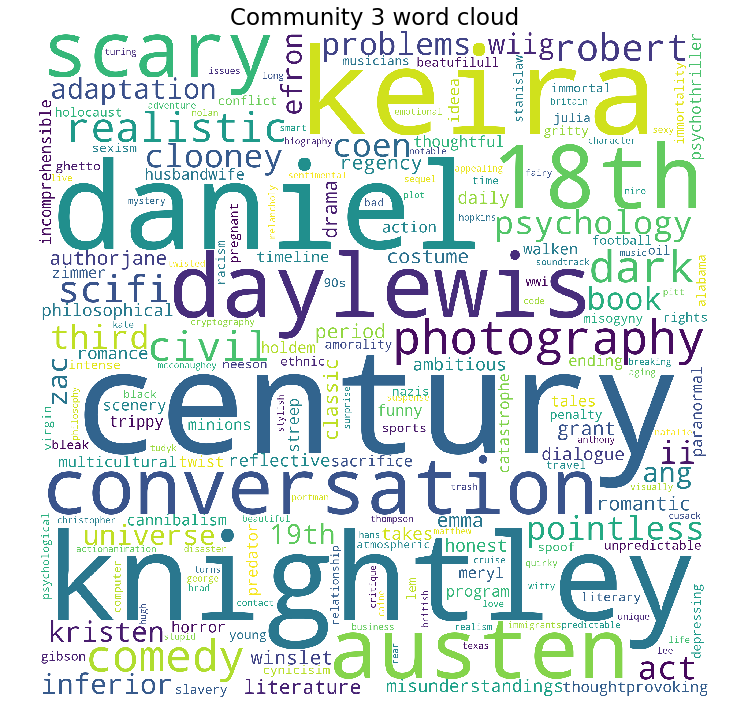

In [190]:
plt.figure(figsize=(12,14))
wordcloud_com3 = WordCloud(stopwords=STOPWORDS, 
                           width=2500, height=2500, 
                           background_color="white",
                           collocations=False).generate(com3_string)
img_com3 = plt.imshow(wordcloud_com3)
plt.axis("off")
plt.title("Community 3 word cloud", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
Words such as `century`, `18th` and `conversation` defines community three. We also see words such as `lewis`, `austen` which are possibly the people related to the movie. For example, `austen` may refer to Jane Austen and the books that are written by her. Her stories are mostly based on the lives in 18th. This corresponds to the highlighted `18th` in the word cloud. Time in the movie production seems to be an important characteristic for this community. The users in this community are likely to have a preference for movies that features the stories during 18th and 19th centuries. They might be in favour of the production by particular writer or actor. 
</div>

- **Community 4**

__TF__

In [124]:
tfs_com4 = {}
totalword = sum(list(com4_tagdict.values()))

for word, count in com4_tagdict.items():
    tf = count/totalword
    tfs_com4[word] = tf 

__IDF__

In [125]:
idfs_com4 = {}
N = 4
n = 0

# process each tag in cluster x
# check how many times the tag appear in the other clusters 
for word in com4_tagdict.keys():
    if word in com1_tagdict.keys() and word in com2_tagdict.keys() and word in com3_tagdict.keys():
        n = 4
    elif word in com1_tagdict.keys() and word in com2_tagdict.keys():
        n = 3
    elif word in com1_tagdict.keys() and word in com3_tagdict.keys():
        n = 3
    elif word in com2_tagdict.keys() and word in com3_tagdict.keys():
        n = 3
    elif word in com1_tagdict.keys() or word in com2_tagdict.keys():
        n = 2
    elif word in com1_tagdict.keys() or word in com3_tagdict.keys():
        n = 2
    elif word in com2_tagdict.keys() or word in com3_tagdict.keys():
        n = 2
    else:
        n = 1
        
    idf = float(math.log2((N/n))) # apply the formula for IDF
    
    idfs_com4[word] = idf

__TF-IDF__

In [126]:
tfidf_com4 = {}

for word, tf in tfs_com4.items():
    tfidf =  tf * idfs_com4[word]
    tfidf_com4[word] = tfidf

In [127]:
com4_sorted_tags = sorted(tfidf_com4.items(), key=lambda x: x[1], reverse=True)
com4_sorted_tags[0:10]

[('education', 0.044444444444444446),
 ('motivation', 0.044444444444444446),
 ('tearjerking', 0.044444444444444446),
 ('benedict', 0.044444444444444446),
 ('cumberbatch', 0.044444444444444446),
 ('enigma', 0.044444444444444446),
 ('informatics', 0.044444444444444446),
 ('mathematicians', 0.044444444444444446),
 ('turing', 0.022222222222222223),
 ('code', 0.022222222222222223)]

__Word cloud__

In [191]:
com4_string = ""

for word, tfidf in tfidf_com4.items():
    for i in range(math.ceil(tfidf*1000)):
        com4_string = com4_string + word + ' '

# print(com4_string)

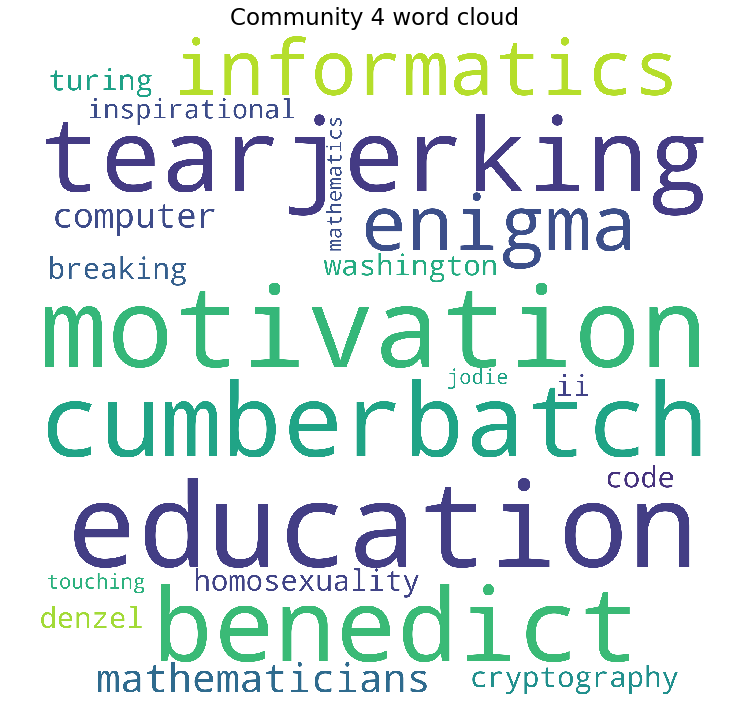

In [192]:
plt.figure(figsize=(12,14))
wordcloud_com4 = WordCloud(stopwords=STOPWORDS, 
                           width=2500, height=2500, 
                           background_color="white",
                           collocations=False).generate(com4_string)
img_com4 = plt.imshow(wordcloud_com4)
plt.axis("off")
plt.title("Community 4 word cloud", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
As we understand previously, community four is much smaller by size compared to other communities. Thus, the tags featured in the word cloud will also be less. It is interesting to note that the top 10 important tags shares the same score. This means that each of these tags hold equal importance in defining community four. Words such as `informatics`, `education`, `tearjerking`, `inspirational` seems to suggest that community four users tend to movies that are more informative and have educational values. In particular, there are quite a number of words that are related to a specifc academic topic such as `informatics`, `crptography` and `code`. 
</div>

<div class="alert alert-block alert-info">
The above tags are rather distinct from one community to another. We suppose that this is because of the movies that users in each communites watched as many of them are actually the charateractics of certain genres of movies. So do users in the same community watch movies of the same genre? The following part is to answer the question.
</div>

### 5.3.3 Common Tags among Communities

In [132]:
# function to find the top frequent tags used 
def find_freq_tag(user_list, num):
    all_tags = []
    tags = user_clean_tags(user_list)
    for user in tags:
        for tag in tags[user]:
            all_tags.append(tag)
    tag_count = dict(Counter(all_tags))    
    results = sorted(tag_count, key=tag_count.get, reverse=True)[:num]
    return results

In [133]:
f1 = find_freq_tag(com1_users, 100)
f2 = find_freq_tag(com2_users, 100)
f3 = find_freq_tag(com3_users, 100)
f4 = find_freq_tag(com4_users, 100)

In [134]:
common_tags = []
a,b,c,d = 0,0,0,0 # count of the current tag from each of the 4 communities

for i in f1:
    if i in f2 and i in f3 and i in f4:
        a = f1.index(i)
        b = f2.index(i)
        c = f3.index(i)
        d = f4.index(i)
    
    common_tags.append([i, a+b+c+d])
    
common_tags = sorted(common_tags, key=lambda x: x[1], reverse=False)

In [135]:
top5_common = [ i[0] for i in common_tags[:5] ]
print("Top 5 common tags given by the three communties users are: ")
print(', '.join(top5_common))

Top 5 common tags given by the three communties users are: 
comedy, horror, action, story, ending


### 5.3.4 Non-common Tags for each Community

In [136]:
# com 1
top_com1 = list(set(f1[:15]) - set(top5_common))[:5]
print("Top 5 non-common tags given by Community 1 users are: ")
print(', '.join(top_com1))

Top 5 non-common tags given by Community 1 users are: 
bad, boring, dark, adventure, twist


In [137]:
# com 2
top_com2 = list(set(f2[:15]) - set(top5_common))[:10]
print("Top 5 non-common tags given by Community 2 users are: ")
print(', '.join(top_com2))

Top 5 non-common tags given by Community 2 users are: 
oscar, love, female, inspirational, friendship, true, predictable, movie, fantasy, great


In [138]:
# com 3
top_com3 = list(set(f3[:15]) - set(top5_common))[:5]
print("Top 5 non-common tags given by Community 3 users are: ")
print(', '.join(top_com3))

Top 5 non-common tags given by Community 3 users are: 
alan, scifi, dark, period, austen


In [139]:
# com 4
top_com4 = list(set(f4[:15]) - set(top5_common))[:5]
print("Top 5 non-common tags given by Community 4 users are: ")
print(', '.join(top_com4))

Top 5 non-common tags given by Community 4 users are: 
motivation, foster, inspirational, true, bittersweet


## 5.4  Movie Genres among Communities

### 5.4.1 Top Movie Genres for each Community

In [140]:
# read in movie data
df_movies = pd.read_csv('../ml-latest/movie_master.txt', encoding='utf-8', sep='\t') # change file path to the one on your laptop
del df_movies['Unnamed: 0']

df_movies['genres'] = df_movies['genres'].str.split('|')
df_movies['tmdbId'] = pd.to_numeric(df_movies['tmdbId'], errors='coerce')

In [141]:
# function to match the movie names and ids 
# return the names of the top movies based on the number of users who have watched 
def find_freq_movie(user_list, num):
    all_movies = []
    movies = user_watch_movies(user_list)
    for user in movies:
        for movie in movies[user]:
            all_movies.append(movie)
    movie_count = dict(Counter(all_movies))    
    results = sorted(movie_count, key=movie_count.get, reverse=True)[:num]
    
    output = []
    
    for i in range(0, len(results)):
        movie_id = results[i]
        output.append((list(df_movies[df_movies['movieId']==movie_id]['title']),
                       list(df_movies[df_movies['movieId']==movie_id]['genres'])))
    
    final = []
    for i in output:
        movie=i[0][0]
        genre=i[1][0]
        final.append([movie, genre])
    return final

In [142]:
'''
## function to return all movie genres in each community
input: community of users 
output: dictionary with 
            1. key - genre
            2. value - count of this genre seen in this community 
'''
def get_movie_genres(user_list):
    all_movies = []
    movies = user_watch_movies(user_list)
    for user in movies:
        for movie in movies[user]:
            all_movies.append(movie)
    unique_movies = list(set(all_movies))
    
    output = []
    for i in range(0, len(unique_movies)):
        movie_id = unique_movies[i]
        genres = df_movies.loc[df_movies['movieId']==movie_id]['genres'].values[0] # returns a list of strings
        for g in genres:
            output.append(g)
    output = dict(Counter(output))

    return output

In [143]:
com1_movie_genres = get_movie_genres(com1_users)
com2_movie_genres = get_movie_genres(com2_users)
com3_movie_genres = get_movie_genres(com3_users)
com4_movie_genres = get_movie_genres(com4_users)

# Since every genres are in all the communities, 
# we will use the top 7 to see if there is any similarities/differences between them
com1_movie_genres = dict(sorted(com1_movie_genres.items(), key=lambda x:x[1], reverse=True))
com2_movie_genres = dict(sorted(com2_movie_genres.items(), key=lambda x:x[1], reverse=True))
com3_movie_genres = dict(sorted(com3_movie_genres.items(), key=lambda x:x[1], reverse=True))
com4_movie_genres = dict(sorted(com4_movie_genres.items(), key=lambda x:x[1], reverse=True))

In [144]:
com1_movie_genres.pop('(no genres listed)',None)
com2_movie_genres.pop('(no genres listed)',None)
com3_movie_genres.pop('(no genres listed)',None)
com4_movie_genres.pop('(no genres listed)',None)

6

- **Community 1**

In [145]:
# top movies for community 1 
find_freq_movie(com1_users, 10)

[['Avengers: Infinity War - Part I (2018)', ['Action', 'Adventure', 'Sci-Fi']],
 ['Deadpool 2 (2018)', ['Action', 'Comedy', 'Sci-Fi']],
 ['Solo: A Star Wars Story (2018)',
  ['Action', 'Adventure', 'Children', 'Sci-Fi']],
 ['Mission: Impossible - Fallout (2018)', ['Action', 'Adventure', 'Thriller']],
 ['Upgrade (2018)', ['Action', 'Comedy', 'Horror', 'Sci-Fi', 'Thriller']],
 ['Coco (2017)', ['Adventure', 'Animation', 'Children']],
 ['Three Billboards Outside Ebbing, Missouri (2017)', ['Crime', 'Drama']],
 ['A Quiet Place (2018)', ['Drama', 'Horror', 'Thriller']],
 ['Isle of Dogs (2018)', ['Animation', 'Comedy']],
 ['Black Panther (2017)', ['Action', 'Adventure', 'Sci-Fi']]]

In [146]:
com1_movie_genres

{'Drama': 1578,
 'Comedy': 1114,
 'Thriller': 908,
 'Action': 768,
 'Horror': 545,
 'Adventure': 525,
 'Sci-Fi': 511,
 'Romance': 471,
 'Crime': 448,
 'Animation': 386,
 'Fantasy': 348,
 'Mystery': 302,
 'Children': 251,
 'Documentary': 155,
 'War': 130,
 'IMAX': 104,
 'Musical': 81,
 'Western': 52,
 'Film-Noir': 31}

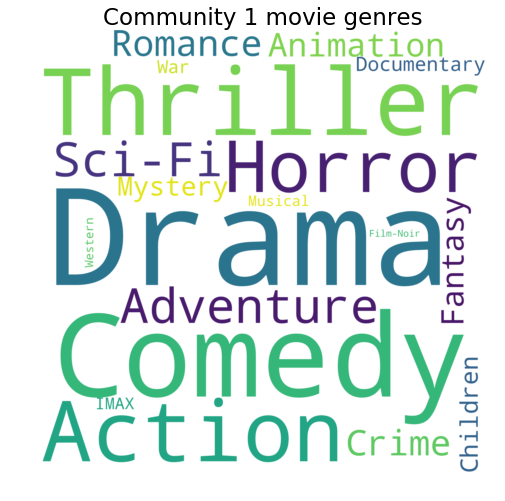

In [147]:
plt.figure(figsize=(8,10))

wordcloud_com1_movie_genres = WordCloud(stopwords=STOPWORDS,
                                        width=2500,
                                        height=2500,
                                        background_color="white",
                                        collocations=False).generate_from_frequencies(com1_movie_genres)

img_com1 = plt.imshow(wordcloud_com1_movie_genres, interpolation="bilinear")
plt.axis("off")
plt.title("Community 1 movie genres", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
We see that users from Community 1 likes to watch `Action`, `Comedy`, `Thriller` movies. We also see that `Horror` stands out next which suggest that these users tend to watch such genre as well.
</div>

- **Community 2**

In [148]:
# top movies for community 2 
find_freq_movie(com2_users, 10)

[['Lord of the Rings: The Return of the King, The (2003)',
  ['Action', 'Adventure', 'Drama', 'Fantasy']],
 ['Lord of the Rings: The Fellowship of the Ring, The (2001)',
  ['Adventure', 'Fantasy']],
 ['Inception (2010)',
  ['Action', 'Crime', 'Drama', 'Mystery', 'Sci-Fi', 'Thriller', 'IMAX']],
 ['Lord of the Rings: The Two Towers, The (2002)', ['Adventure', 'Fantasy']],
 ['Gladiator (2000)', ['Action', 'Adventure', 'Drama']],
 ['Forrest Gump (1994)', ['Comedy', 'Drama', 'Romance', 'War']],
 ['Avatar (2009)', ['Action', 'Adventure', 'Sci-Fi', 'IMAX']],
 ['Ratatouille (2007)', ['Animation', 'Children', 'Drama']],
 ['Back to the Future (1985)', ['Adventure', 'Comedy', 'Sci-Fi']],
 ['Grand Budapest Hotel, The (2014)', ['Comedy', 'Drama']]]

In [149]:
com2_movie_genres

{'Drama': 3338,
 'Comedy': 2448,
 'Thriller': 1673,
 'Action': 1491,
 'Romance': 1130,
 'Adventure': 1016,
 'Sci-Fi': 935,
 'Crime': 928,
 'Horror': 800,
 'Fantasy': 622,
 'Animation': 529,
 'Mystery': 500,
 'Children': 494,
 'War': 318,
 'Documentary': 262,
 'Musical': 222,
 'IMAX': 152,
 'Western': 119,
 'Film-Noir': 68}

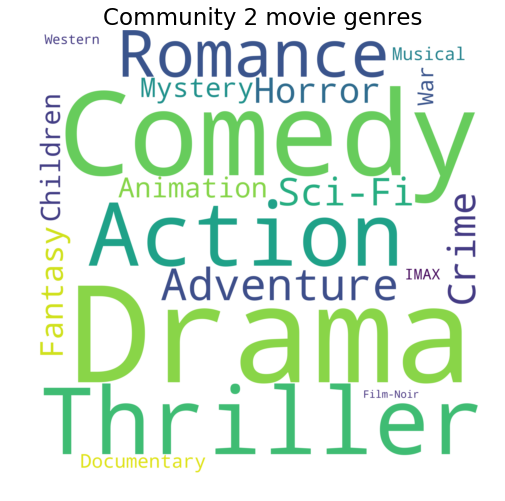

In [150]:
plt.figure(figsize=(8,10))

wordcloud_com2_movie_genres = WordCloud(stopwords=STOPWORDS,
                                        width=2500,
                                        height=2500,
                                        background_color="white",
                                        collocations=False).generate_from_frequencies(com2_movie_genres)

img_com2 = plt.imshow(wordcloud_com2_movie_genres, interpolation="bilinear")
plt.axis("off")
plt.title("Community 2 movie genres", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
We see that users from Community 2 likes to watch `Drama`, `Comedy`, `Thriller` and `Action` movies. `Romance` and `Adventure` seems to stand out next which suggest this genre could be distinctive to this community.
</div>

- **Community 3**

In [151]:
# top movies for community 3 
find_freq_movie(com3_users, 10)

[['Shawshank Redemption, The (1994)', ['Crime', 'Drama']],
 ['Matrix, The (1999)', ['Action', 'Sci-Fi', 'Thriller']],
 ['Fight Club (1999)', ['Action', 'Crime', 'Drama', 'Thriller']],
 ['Inception (2010)',
  ['Action', 'Crime', 'Drama', 'Mystery', 'Sci-Fi', 'Thriller', 'IMAX']],
 ['Lord of the Rings: The Return of the King, The (2003)',
  ['Action', 'Adventure', 'Drama', 'Fantasy']],
 ['Pulp Fiction (1994)', ['Comedy', 'Crime', 'Drama', 'Thriller']],
 ['Lord of the Rings: The Fellowship of the Ring, The (2001)',
  ['Adventure', 'Fantasy']],
 ['Lord of the Rings: The Two Towers, The (2002)', ['Adventure', 'Fantasy']],
 ["Schindler's List (1993)", ['Drama', 'War']],
 ['Forrest Gump (1994)', ['Comedy', 'Drama', 'Romance', 'War']]]

In [152]:
com3_movie_genres

{'Drama': 1169,
 'Comedy': 721,
 'Action': 561,
 'Thriller': 534,
 'Romance': 401,
 'Adventure': 364,
 'Crime': 362,
 'Sci-Fi': 304,
 'Fantasy': 209,
 'Mystery': 188,
 'Horror': 164,
 'Animation': 155,
 'Children': 129,
 'War': 97,
 'Documentary': 94,
 'IMAX': 77,
 'Musical': 59,
 'Western': 35,
 'Film-Noir': 21}

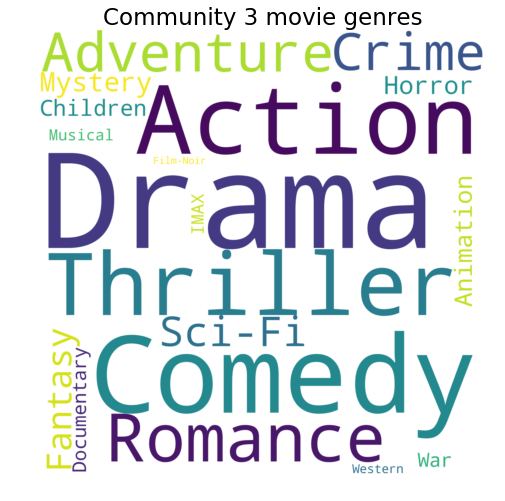

In [153]:
plt.figure(figsize=(8,10))

wordcloud_com3_movie_genres = WordCloud(stopwords=STOPWORDS,
          width=2500, 
          height=2500, 
          background_color="white",
          collocations=False).generate_from_frequencies(com3_movie_genres)

img_com3 = plt.imshow(wordcloud_com3_movie_genres, interpolation="bilinear")
plt.axis("off")
plt.title("Community 3 movie genres", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
Like the previous two communities, users from Community 3 likes to watch `Action`, `Comedy`, `Thriller` and `Drama` movies. The distinct genres here could be `Romance` and `Sci-Fi`.
</div>

- **Community 4**

In [154]:
# top movies for community 4
find_freq_movie(com4_users, 10)

[['Pirates of the Caribbean: The Curse of the Black Pearl (2003)',
  ['Action', 'Adventure', 'Comedy', 'Fantasy']],
 ['Deadpool (2016)', ['Action', 'Adventure', 'Comedy', 'Sci-Fi']],
 ['Harry Potter and the Goblet of Fire (2005)',
  ['Adventure', 'Fantasy', 'Thriller', 'IMAX']],
 ['Inception (2010)',
  ['Action', 'Crime', 'Drama', 'Mystery', 'Sci-Fi', 'Thriller', 'IMAX']],
 ['Guardians of the Galaxy (2014)', ['Action', 'Adventure', 'Sci-Fi']],
 ['Lord of the Rings: The Fellowship of the Ring, The (2001)',
  ['Adventure', 'Fantasy']],
 ['Harry Potter and the Prisoner of Azkaban (2004)',
  ['Adventure', 'Fantasy', 'IMAX']],
 ['Lord of the Rings: The Return of the King, The (2003)',
  ['Action', 'Adventure', 'Drama', 'Fantasy']],
 ['Matrix, The (1999)', ['Action', 'Sci-Fi', 'Thriller']],
 ['Lord of the Rings: The Two Towers, The (2002)', ['Adventure', 'Fantasy']]]

In [155]:
com4_movie_genres

{'Action': 339,
 'Drama': 335,
 'Comedy': 282,
 'Adventure': 264,
 'Thriller': 229,
 'Sci-Fi': 201,
 'Romance': 139,
 'Crime': 130,
 'Fantasy': 119,
 'Animation': 97,
 'Children': 83,
 'IMAX': 80,
 'Mystery': 68,
 'Horror': 56,
 'War': 34,
 'Musical': 27,
 'Western': 11,
 'Documentary': 9,
 'Film-Noir': 3}

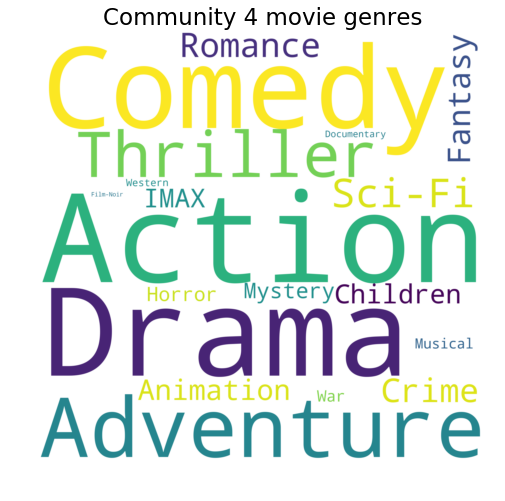

In [156]:
plt.figure(figsize=(8,10))

wordcloud_com4_movie_genres = WordCloud(stopwords=STOPWORDS,
                                        width=2500,
                                        height=2500,
                                        background_color="white",
                                        collocations=False).generate_from_frequencies(com4_movie_genres)

img_com4 = plt.imshow(wordcloud_com4_movie_genres, interpolation="bilinear")
plt.axis("off")
plt.title("Community 4 movie genres", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
Like the previous three communities, users from Community 3 likes to watch `Action`, `Drama` and `Comedy` movies. Surprisingly, `Thriller` is not the top in the list of most watched genres. We also observed that users from Community 4 have a tendency to watch `Adventure` genre as well.
</div>

---

__<u>Conclusion</u>__

<div class="alert alert-block alert-info">
As we observed, `Action`, `Comedy` and `Drama` are the most common movie genres among users from all four communities we have. Tags which are likely to be associated with Action movies such as "*predictable*", "*dark*" and "*twist*" are thus the top common tags for all communities. 
<br><br>
On the other hand, we also notices the difference in the communities.
<br><br>
Other than Action movies, Community 1 users tend to watch `Horror` movies which explains its unique tags such as "*atmospheric*". Users in Community 2 tend to watch `Romance` and `Adventure` movies, thus the top unique tags for them are words like "*love*", "*romance*" and "*inspirational*". Community 3 users prefer movies of `Sci-Fi` and `Romance`. This leads to tags such as "*romantic*" and "*scifi*". While users from Community 4 are more interested in `Adventure` and `Thriller` movies. This aligns with its top tags of "*survival*" and "*foster*" (foster relationships during an adventure). 
</div>



### 5.4.2 Distinct Movie Genres for each Community

In [157]:
com1_movie_genres = dict(sorted(com1_movie_genres.items(), key=lambda x:x[1], reverse=True)[0:10])
com2_movie_genres = dict(sorted(com2_movie_genres.items(), key=lambda x:x[1], reverse=True)[0:10])
com3_movie_genres = dict(sorted(com3_movie_genres.items(), key=lambda x:x[1], reverse=True)[0:10])
com4_movie_genres = dict(sorted(com4_movie_genres.items(), key=lambda x:x[1], reverse=True)[0:10])

- **Community 1**

__TF__

In [158]:
tfs_com1_movie_genres = {}
totalword = sum(list(com1_movie_genres.values()))

for word, count in com1_movie_genres.items():
    tf = count/totalword
    tfs_com1_movie_genres[word] = tf 

__IDF__

In [159]:
idfs_com1_movie_genres = {}
N = 4
n = 0

# process each tag in cluster x
# check how many times the tag appear in the other clusters 
for word in com1_movie_genres.keys():
    if word in com2_movie_genres.keys() and word in com3_movie_genres.keys() and word in com4_movie_genres.keys():
        n = 4
    elif word in com2_movie_genres.keys() and word in com3_movie_genres.keys():
        n = 3
    elif word in com2_movie_genres.keys() and word in com4_movie_genres.keys():
        n = 3
    elif word in com3_movie_genres.keys() and word in com4_movie_genres.keys():
        n = 3
    elif word in com2_movie_genres.keys() or word in com3_movie_genres.keys():
        n = 2
    elif word in com2_movie_genres.keys() or word in com4_movie_genres.keys():
        n = 2
    elif word in com3_movie_genres.keys() or word in com4_movie_genres.keys():
        n = 2
    else:
        n = 1
        
    idf = float(math.log2((N/n))) # apply the formula for IDF
    
    idfs_com1_movie_genres[word] = idf

__TF-IDF__

In [160]:
tfidf_com1_movie_genres = {}

for word, tf in tfs_com1_movie_genres.items():
    tfidf =  tf * idfs_com1_movie_genres[word]
    tfidf_com1_movie_genres[word] = tfidf

In [161]:
com1_sorted_tags = sorted(tfidf_com1_movie_genres.items(), key=lambda x: x[1], reverse=True)
print("The top 10 most important tags in Community 1 are:\n")
com1_sorted_tags[0:10]

The top 10 most important tags in Community 1 are:



[('Horror', 0.07513096222773642),
 ('Animation', 0.05321202095395644),
 ('Drama', 0.0),
 ('Comedy', 0.0),
 ('Thriller', 0.0),
 ('Action', 0.0),
 ('Adventure', 0.0),
 ('Sci-Fi', 0.0),
 ('Romance', 0.0),
 ('Crime', 0.0)]

__Word cloud__

In [193]:
com1_movie_genres_string = ""

for word, tfidf in tfidf_com1_movie_genres.items():
    for i in range(math.ceil(tfidf*1000)):
        com1_movie_genres_string = com1_movie_genres_string + word + ' '

# print(com1_movie_genres_string)

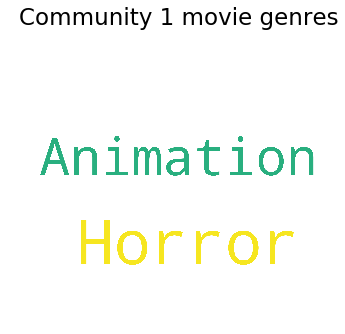

In [195]:
plt.figure(figsize=(5,9))
wordcloud_com1_movie_genres = WordCloud(stopwords=STOPWORDS, 
                                        width=2500, 
                                        height=2500, 
                                        background_color="white",
                                        collocations=False).generate(com1_movie_genres_string)
img_com1 = plt.imshow(wordcloud_com1_movie_genres)
plt.axis("off")
plt.title("Community 1 movie genres", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
We see that the distinct genres in Community 1 are `Animation` and `Horror`. 
</div>

---

- **Community 2**

__TF__

In [164]:
tfs_com2_movie_genres = {}
totalword = sum(list(com2_movie_genres.values()))

for word, count in com2_movie_genres.items():
    tf = count/totalword
    tfs_com2_movie_genres[word] = tf 

__IDF__

In [165]:
idfs_com2_movie_genres = {}
N = 4
n = 0

# process each tag in cluster x
# check how many times the tag appear in the other clusters 
for word in com2_movie_genres.keys():
    if word in com1_movie_genres.keys() and word in com3_movie_genres.keys() and word in com4_movie_genres.keys():
        n = 4
    elif word in com1_movie_genres.keys() and word in com3_movie_genres.keys():
        n = 3
    elif word in com1_movie_genres.keys() and word in com4_movie_genres.keys():
        n = 3
    elif word in com3_movie_genres.keys() and word in com4_movie_genres.keys():
        n = 3
    elif word in com1_movie_genres.keys() or word in com3_movie_genres.keys():
        n = 2
    elif word in com1_movie_genres.keys() or word in com4_movie_genres.keys():
        n = 2
    elif word in com3_movie_genres.keys() or word in com4_movie_genres.keys():
        n = 2
    else:
        n = 1
        
    idf = float(math.log2((N/n))) # apply the formula for IDF
    
    idfs_com2_movie_genres[word] = idf

__TF-IDF__

In [166]:
tfidf_com2_movie_genres = {}

for word, tf in tfs_com2_movie_genres.items():
    tfidf =  tf * idfs_com2_movie_genres[word]
    tfidf_com2_movie_genres[word] = tfidf

In [167]:
com2_sorted_tags = sorted(tfidf_com2_movie_genres.items(), key=lambda x: x[1], reverse=True)
print("The top 10 most important movie genres in Community 2 are:\n")
com2_sorted_tags[0:10]

The top 10 most important movie genres in Community 2 are:



[('Horror', 0.05562895487101036),
 ('Fantasy', 0.01795099955159174),
 ('Drama', 0.0),
 ('Comedy', 0.0),
 ('Thriller', 0.0),
 ('Action', 0.0),
 ('Romance', 0.0),
 ('Adventure', 0.0),
 ('Sci-Fi', 0.0),
 ('Crime', 0.0)]

__Word cloud__

In [196]:
com2_movie_genres_string = ""

for word, tfidf in tfidf_com2_movie_genres.items():
    for i in range(math.ceil(tfidf*1000)):
        com2_movie_genres_string = com2_movie_genres_string + word + ' '

# print(com2_movie_genres_string)

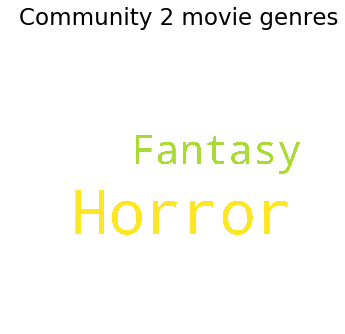

In [197]:
plt.figure(figsize=(5,8))
wordcloud_com2_movie_genres = WordCloud(stopwords=STOPWORDS, 
                                        width=2500, 
                                        height=2500, 
                                        background_color="white", 
                                        collocations=False).generate(com2_movie_genres_string)
img_com2 = plt.imshow(wordcloud_com2_movie_genres)
plt.axis("off")
plt.title("Community 2 movie genres", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
We see that the distinct genres in Community 2 are `Fantasy` and `Horror`. 
</div>

---

- **Community 3**

__TF__

In [170]:
tfs_com3_movie_genres = {}
totalword = sum(list(com3_movie_genres.values()))

for word, count in com3_movie_genres.items():
    tf = count/totalword
    tfs_com3_movie_genres[word] = tf 

__IDF__

In [171]:
idfs_com3_movie_genres = {}
N = 4
n = 0

# process each tag in cluster x
# check how many times the tag appear in the other clusters 
for word in com3_movie_genres.keys():
    if word in com1_movie_genres.keys() and word in com2_movie_genres.keys() and word in com4_movie_genres.keys():
        n = 4
    elif word in com1_movie_genres.keys() and word in com2_movie_genres.keys():
        n = 3
    elif word in com1_movie_genres.keys() and word in com4_movie_genres.keys():
        n = 3
    elif word in com2_movie_genres.keys() and word in com4_movie_genres.keys():
        n = 3
    elif word in com1_movie_genres.keys() or word in com2_movie_genres.keys():
        n = 2
    elif word in com1_movie_genres.keys() or word in com4_movie_genres.keys():
        n = 2
    elif word in com2_movie_genres.keys() or word in com4_movie_genres.keys():
        n = 2
    else:
        n = 1
        
    idf = float(math.log2((N/n))) # apply the formula for IDF
    
    idfs_com3_movie_genres[word] = idf

__TF-IDF__

In [172]:
tfidf_com3_movie_genres = {}

for word, tf in tfs_com3_movie_genres.items():
    tfidf =  tf * idfs_com3_movie_genres[word]
    tfidf_com3_movie_genres[word] = tfidf

In [173]:
com3_sorted_tags = sorted(tfidf_com3_movie_genres.items(), key=lambda x: x[1], reverse=True)
print("The top 10 most important movie genres in Community 3 are:\n")
com3_sorted_tags[0:10]

The top 10 most important movie genres in Community 3 are:



[('Mystery', 0.07812175358404322),
 ('Fantasy', 0.018022613203673037),
 ('Drama', 0.0),
 ('Comedy', 0.0),
 ('Action', 0.0),
 ('Thriller', 0.0),
 ('Romance', 0.0),
 ('Adventure', 0.0),
 ('Crime', 0.0),
 ('Sci-Fi', 0.0)]

__Word cloud__

In [174]:
com3_movie_genres_string = ""

for word, tfidf in tfidf_com3_movie_genres.items():
    for i in range(math.ceil(tfidf*1000)):
        com3_movie_genres_string = com3_movie_genres_string + word + ' '

# print(com3_movie_genres_string)

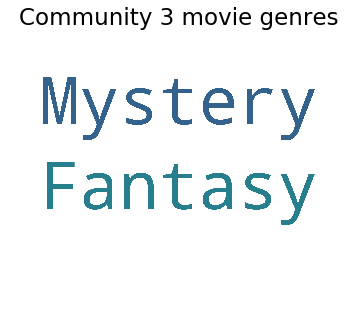

In [198]:
plt.figure(figsize=(5,7))
wordcloud_com3_movie_genres = WordCloud(stopwords=STOPWORDS, 
                                        width=2500, 
                                        height=2500, 
                                        background_color="white",
                                        collocations=False).generate(com3_movie_genres_string)
img_com3 = plt.imshow(wordcloud_com3_movie_genres)
plt.axis("off")
plt.title("Community 3 movie genres", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
We see that the distinct genres in Community 3 are `Fantasy` and `Mystery`. 
</div>

---

- **Community 4**

__TF__

In [176]:
tfs_com4_movie_genres = {}
totalword = sum(list(com4_movie_genres.values()))

for word, count in com4_movie_genres.items():
    tf = count/totalword
    tfs_com4_movie_genres[word] = tf 

In [177]:
tfs_com4_movie_genres

{'Action': 0.15878220140515223,
 'Drama': 0.15690866510538642,
 'Comedy': 0.13208430913348945,
 'Adventure': 0.12365339578454333,
 'Thriller': 0.10725995316159251,
 'Sci-Fi': 0.09414519906323185,
 'Romance': 0.06510538641686182,
 'Crime': 0.06088992974238876,
 'Fantasy': 0.05573770491803279,
 'Animation': 0.04543325526932084}

__IDF__

In [178]:
idfs_com4_movie_genres = {}
N = 4
n = 0

# process each tag in cluster x
# check how many times the tag appear in the other clusters 
for word in com4_movie_genres.keys():
    if word in com1_movie_genres.keys() and word in com2_movie_genres.keys() and word in com3_movie_genres.keys():
        n = 4
    elif word in com1_movie_genres.keys() and word in com2_movie_genres.keys():
        n = 3
    elif word in com1_movie_genres.keys() and word in com3_movie_genres.keys():
        n = 3
    elif word in com2_movie_genres.keys() and word in com3_movie_genres.keys():
        n = 3
    elif word in com1_movie_genres.keys() or word in com2_movie_genres.keys():
        n = 2
    elif word in com1_movie_genres.keys() or word in com3_movie_genres.keys():
        n = 2
    elif word in com2_movie_genres.keys() or word in com3_movie_genres.keys():
        n = 2
    else:
        n = 1
        
    idf = float(math.log2((N/n))) # apply the formula for IDF
    
    idfs_com4_movie_genres[word] = idf

__TF-IDF__

In [179]:
tfidf_com4_movie_genres = {}

for word, tf in tfs_com4_movie_genres.items():
    tfidf =  tf * idfs_com4_movie_genres[word]
    tfidf_com4_movie_genres[word] = tfidf

In [180]:
com4_sorted_tags = sorted(tfidf_com4_movie_genres.items(), key=lambda x: x[1], reverse=True)
print("The top 10 most important movie genres in Community 4 are:\n")
com4_sorted_tags[0:10]

The top 10 most important movie genres in Community 4 are:



[('Animation', 0.04543325526932084),
 ('Fantasy', 0.023133237664722438),
 ('Action', 0.0),
 ('Drama', 0.0),
 ('Comedy', 0.0),
 ('Adventure', 0.0),
 ('Thriller', 0.0),
 ('Sci-Fi', 0.0),
 ('Romance', 0.0),
 ('Crime', 0.0)]

__Word cloud__

In [181]:
com4_movie_genres_string = ""

for word, tfidf in tfidf_com4_movie_genres.items():
    for i in range(math.ceil(tfidf*1000)):
        com4_movie_genres_string = com4_movie_genres_string + word + ' '

# print(com3_movie_genres_string)

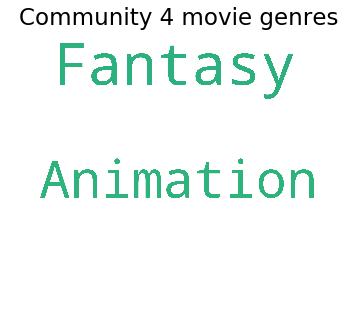

In [199]:
plt.figure(figsize=(5,7))
wordcloud_com4_movie_genres = WordCloud(stopwords=STOPWORDS, 
                                        width=2500, 
                                        height=2500, 
                                        background_color="white",
                                        collocations=False).generate(com4_movie_genres_string)
img_com4 = plt.imshow(wordcloud_com4_movie_genres)
plt.axis("off")
plt.title("Community 4 movie genres", fontsize=23)
plt.show()

<div class="alert alert-block alert-info">
We see that the distinct genres in Community 4 are `Animation` and `Fantasy`. 
</div>

---

__<u>Conclusion</u>__

<div class="alert alert-block alert-info">
As seen from all the word clouds, we see that there are a combination of genres that are distinct among the communities. For example in community 1, we see that `Horror` and `Animation` genres is unique to them. This aligns with the top tags found such as "*atmospheric*". 
<br><br>
Through our text analysis of tags, we found that while these communities do share some similarities between them, they also their distinct differences between them. Thus, we would think that forming these communities by movie genres is indeed a reasonable assumption.
</div>